In [1]:
import pandas as pd
import numpy as np
from dfply import *

In [2]:
from pathlib import Path
data_dir = Path("./data/reports/avg_results")

In [3]:
baseline_files = list(data_dir.glob("**/*baseline*"))
result_files = list(data_dir.glob("**/*cw*"))

In [4]:
b_dfs = []
for file in baseline_files:
    parts = file.name.split("_")
    graph_type, graph_type_no = parts[1], parts[2]
    df = pd.read_csv(file)
    df['graph_type'] = graph_type
    df['graph_type_no'] = graph_type_no
    df['alpha'] = np.NaN
    df['exponent'] = np.NaN
    df.drop(columns=[col for col in df.columns if col.startswith("support")] + ["sens_attr"], inplace=True)
    df.loc[df.attribute == 'other', 'attribute'] = 'location'
    df.loc[df.attribute == 'sensitive', 'attribute'] = 'age'
    df.graph_type = pd.Categorical(df.graph_type, categories=["distinct", "semi", "mixed"])
    id_vars = ["alpha", "exponent", "p", "q", "attribute", "graph_type", "graph_type_no"]
    long_df = pd.melt(df, id_vars = id_vars, var_name='metric', value_name='value')
    b_dfs.append(long_df)
baseline_df = pd.concat(b_dfs)
baseline_df.head()

,alpha,exponent,p,q,attribute,graph_type,graph_type_no,metric,value
0,NaN,NaN,1.0,0.1,location,distinct,2,f1_macro,0.874633
1,NaN,NaN,1.0,0.1,age,distinct,2,f1_macro,0.691336
2,NaN,NaN,0.1,5.0,location,distinct,2,f1_macro,0.865144
3,NaN,NaN,0.1,5.0,age,distinct,2,f1_macro,0.671033
4,NaN,NaN,10.0,1.0,location,distinct,2,f1_macro,0.873774


In [5]:
r_dfs = []
for file in result_files:
    parts = file.name.split("_")
    graph_type, graph_type_no = parts[1], parts[2]
    df = pd.read_csv(file)
    df['graph_type'] = graph_type
    df['graph_type_no'] = graph_type_no
    df.drop(columns=[col for col in df.columns if col.startswith("support")], inplace=True)
    df.sens_attr = df.sens_attr.str.lower()
    df.loc[df.sens_attr == 'region', 'sens_attr'] = 'location'
    df.graph_type = pd.Categorical(df.graph_type, categories=["distinct", "semi", "mixed"])
    id_vars = ["alpha", "exponent", "p", "q", "sens_attr", "attribute", "graph_type", "graph_type_no"]
    long_df = pd.melt(df, id_vars = id_vars, var_name='metric', value_name='value')
    r_dfs.append(long_df)
all_results_df = pd.concat(r_dfs)
all_results_df.head()

,alpha,exponent,p,q,sens_attr,attribute,graph_type,graph_type_no,metric,value
0,0.05,15,0.5,1.0,age,other,distinct,0,f1_macro,0.978841
1,0.05,15,0.5,1.0,age,sensitive,distinct,0,f1_macro,0.816718
2,0.75,1,0.1,10.0,age,other,distinct,0,f1_macro,0.952890
3,0.75,1,0.1,10.0,age,sensitive,distinct,0,f1_macro,0.449638
4,0.95,3,5.0,10.0,age,other,distinct,0,f1_macro,0.978078


In [6]:
results_df = all_results_df >> filter_by(X.alpha.isin([0.01, 0.25, 0.5, 0.75, 0.99]))
results_df.head()

,alpha,exponent,p,q,sens_attr,attribute,graph_type,graph_type_no,metric,value
2,0.75,1,0.1,10.0,age,other,distinct,0,f1_macro,0.952890
3,0.75,1,0.1,10.0,age,sensitive,distinct,0,f1_macro,0.449638
6,0.99,5,0.5,0.1,age,other,distinct,0,f1_macro,0.979109
7,0.99,5,0.5,0.1,age,sensitive,distinct,0,f1_macro,0.373017
8,0.75,11,1.0,10.0,age,other,distinct,0,f1_macro,0.980507


In [7]:
import plotnine as p9
p9.options.figure_size = (8, 6)
p9.options.current_theme = p9.theme_bw(base_size=18)

In [8]:
from plotnine import *

In [9]:
results_dir = Path("results_workshop")

# Part 1 - Fairness analysis

## Baseline: node2vec

In [10]:
baseline_dir = results_dir / "baseline"
image_dir = baseline_dir / "images"
table_dir = baseline_dir / "tables"
image_dir.mkdir(exist_ok=True, parents=True)
table_dir.mkdir(exist_ok=True, parents=True)

def baseline(baseline_df, attr, metric_name, agg_func, transform_func):
    sort_vals = ['p', 'q', 'graph_type', 'graph_type_no', 'metric']
    group_vals = sort_vals[:-1] # exclude metric
    
    baseline_data = (
        baseline_df >> 
        filter_by(X.attribute == attr, X.metric.str.match('f1_macro_class_\d$')) >> 
        group_by(*group_vals) >>
        summarize(metric = agg_func(X.value))
    )
    plot_data = baseline_data >> group_by(X.graph_type, X.p, X.q) >> summarize(val = np.mean(X.metric))
    facet_plot = (
        ggplot(plot_data) + 
        geom_tile(aes(x="factor(p)", y="factor(q)", fill="val")) + 
        facet_wrap('graph_type', ncol=3) +
        labs(x='p', y='q', fill=f"{metric_name} ({attr})")
    )

    conf = (
        baseline_data >> 
        group_by(X.graph_type, X.graph_type_no) >> 
        filter_by(X.metric == transform_func(X.metric)) >> 
        ungroup() >> 
        arrange(X.graph_type, X.graph_type_no) >> 
        select(X.graph_type, X.graph_type_no, X.p, X.q, X.metric) >>
        rename(**{metric_name: 'metric'})
    )
    conf.reset_index(drop=True)
    conf['sens_attr'] = attr

    return facet_plot, conf

In [11]:
region_fairness_plot, region_fairness_conf_baseline = baseline(baseline_df, 'location', 'disparity', np.var, np.min)

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

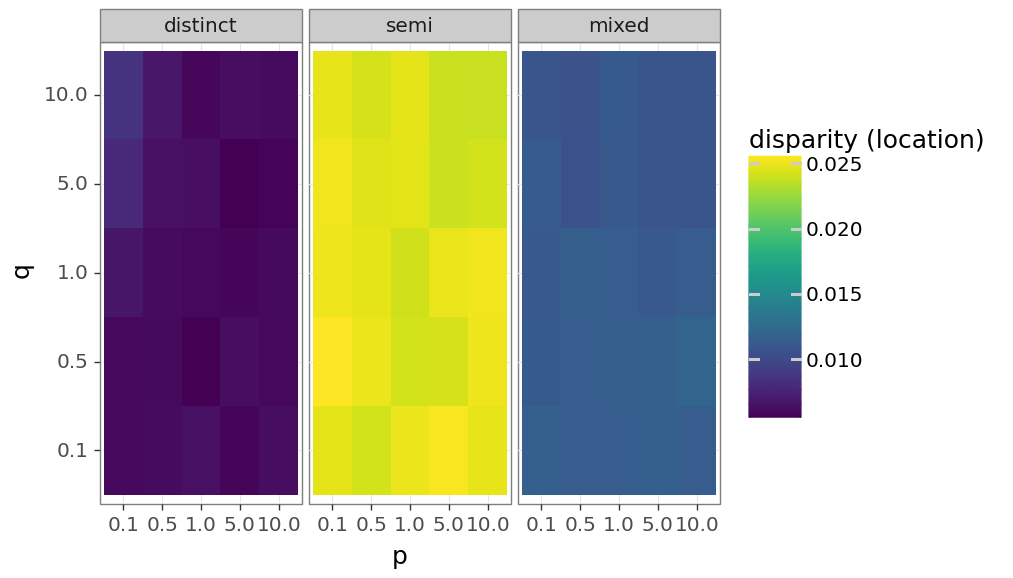

<ggplot: (301493846)>

In [12]:
region_fairness_plot.save(image_dir / "fairness_region.svg", verbose=False, dpi=200)
region_fairness_plot

In [13]:
attr_order = ["graph_type", "graph_type_no", "p", "q", "disparity"]
region_fairness_conf_baseline[attr_order].to_latex(table_dir / "fairness_region.tex")

region_fairness_conf_baseline[attr_order + ["sens_attr"]]

,graph_type,graph_type_no,p,q,disparity,sens_attr
90,distinct,0,1.0,0.1,0.000060,location
127,distinct,1,1.0,10.0,0.006442,location
164,distinct,2,5.0,5.0,0.011251,location
39,semi,0,0.1,10.0,0.012046,location
220,semi,1,10.0,10.0,0.040500,location
176,semi,2,5.0,10.0,0.016265,location
78,mixed,0,0.5,5.0,0.009601,location
43,mixed,1,0.1,10.0,0.011476,location
44,mixed,2,0.1,10.0,0.009232,location


In [14]:
age_fairness_plot, age_fairness_conf_baseline = baseline(baseline_df, 'age', 'disparity', np.var, np.min)

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

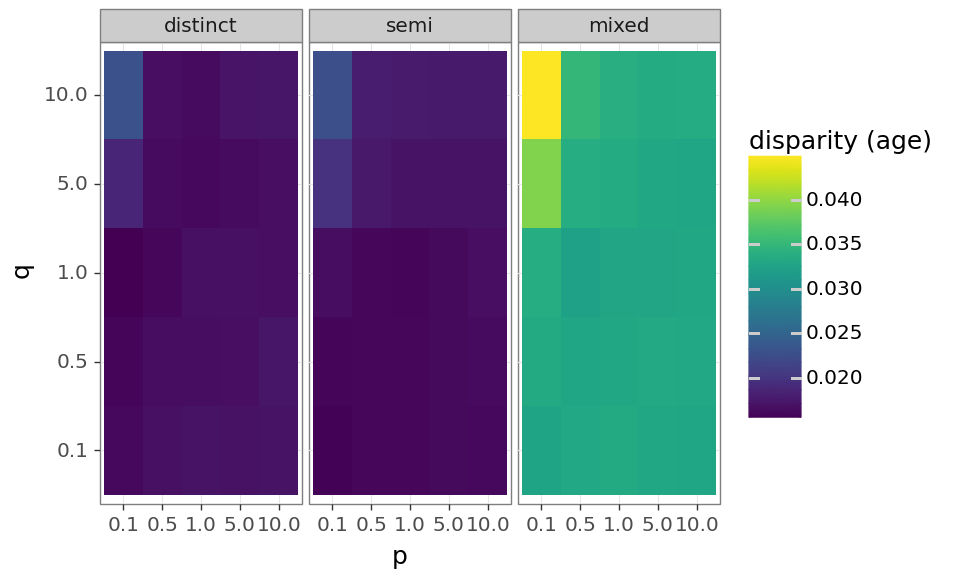

<ggplot: (874470319)>

In [15]:
age_fairness_plot.save(image_dir / "fairness_age.svg", verbose=False, dpi=200)
age_fairness_plot

In [16]:
attr_order = ["graph_type", "graph_type_no", "p", "q", "disparity"]
age_fairness_conf_baseline[attr_order].to_latex(table_dir / "fairness_age.tex")

age_fairness_conf_baseline[attr_order + ["sens_attr"]]

,graph_type,graph_type_no,p,q,disparity,sens_attr
18,distinct,0,0.1,1.0,0.016759,age
10,distinct,1,0.1,0.5,0.015287,age
11,distinct,2,0.1,0.5,0.015995,age
111,semi,0,1.0,1.0,0.021415,age
13,semi,1,0.1,0.5,0.015281,age
5,semi,2,0.1,0.1,0.012566,age
69,mixed,0,0.5,1.0,0.042495,age
16,mixed,1,0.1,0.5,0.015776,age
71,mixed,2,0.5,1.0,0.038272,age


## CrossWalk

In [17]:
cw_dir = results_dir / "crosswalk"
image_dir = cw_dir / "images"
table_dir = cw_dir / "tables"
image_dir.mkdir(exist_ok=True, parents=True)
table_dir.mkdir(exist_ok=True, parents=True)

def crosswalk(results_df, attr, metric_name, agg_func, transform_func, use_sens_attr=True):
    
    sort_vals = ['alpha', 'exponent', 'p', 'q', 'graph_type', 'graph_type_no', 'metric']
    group_vals = sort_vals[:-1] # exclude metric
    
    if not use_sens_attr: 
        label = f"{metric_name} ({attr}) [control]"
        attr = 'location' if attr == 'age' else 'age'
        attribute_string = 'other'  
    else:
        attribute_string = 'sensitive'
        label = f"{metric_name} ({attr})\n[sensitive]"
    label=metric_name

    attr_order = ["graph_type", "graph_type_no", "alpha", "exponent", "p", "q"] + [metric_name]

    data = (
        results_df >> 
        filter_by(X.sens_attr == attr, X.attribute == attribute_string, X.metric.str.match('f1_macro_class_\d$')) >> 
        group_by(*group_vals) >>
        summarize(metric = agg_func(X.value))
    )
    plot_data = data >> group_by(X.graph_type, X.p, X.q) >> summarize(val = np.mean(X.metric))
    pq_plot = (
        ggplot(plot_data) + 
        geom_tile(aes(x="factor(p)", y="factor(q)", fill="val")) + 
        facet_wrap('graph_type', ncol=3) +
        labs(x='p', y='q', fill=label)
    )

    # merge_attrs = ['graph_type', 'graph_type_no', 'p', 'q']
    # data = data >> right_join(n2v_conf >> select(*merge_attrs), by=merge_attrs)
    plot_data = data >> group_by(X.graph_type, X.alpha, X.exponent) >> summarize(val = np.mean(X.metric))
    facet_plot = (
        ggplot(plot_data) + 
        geom_tile(aes(x="factor(alpha)", y="factor(exponent)", fill="val")) + 
        facet_wrap('graph_type', ncol=3) +
        labs(x='alpha', y='exponent', fill=label) 
    )

    conf = (
        data >> 
        group_by(X.graph_type, X.graph_type_no) >> 
        filter_by(X.metric == transform_func(X.metric)) >> 
        ungroup() >> 
        arrange(X.graph_type, X.graph_type_no) >> 
        select(*sort_vals) >>
        rename(**{metric_name: 'metric'})
    )
    conf.reset_index(drop=True)
    conf['sens_attr'] = attr

    return pq_plot, facet_plot, conf

In [18]:
region_fairness_pq_plot, region_fairness_plot, region_fairness_conf_cw = \
    crosswalk(results_df, 'location', 'disparity', np.var, np.min, use_sens_attr=True)

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

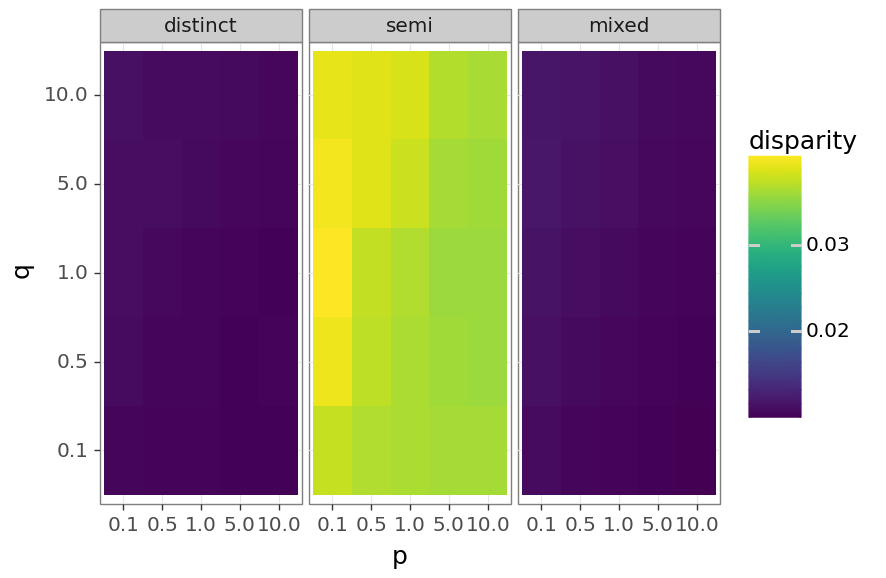

<ggplot: (402037043)>

In [19]:
region_fairness_pq_plot.save(image_dir / "fairness_pq_region_sens.svg", verbose=False, dpi=200)
region_fairness_pq_plot

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

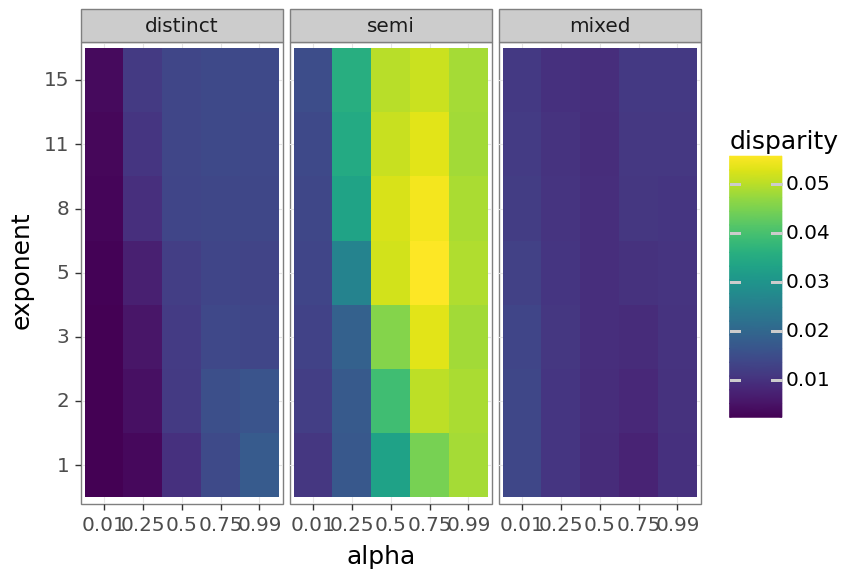

<ggplot: (877734994)>

In [20]:
region_fairness_plot.save(image_dir / "fairness_region_sens.svg", verbose=False, dpi=200)
region_fairness_plot

In [21]:
attr_order = ["graph_type", "graph_type_no", "alpha", "exponent", "p", "q", "disparity"]
region_fairness_conf_cw[attr_order].to_latex(table_dir / "fairness_region.tex")

region_fairness_conf_cw

,alpha,exponent,p,q,graph_type,graph_type_no,disparity,sens_attr
4509,0.50,15,0.1,0.5,distinct,0,0.000007,location
6769,0.99,3,0.1,1.0,distinct,1,0.000481,location
371,0.01,2,5.0,0.5,distinct,2,0.004162,location
30,0.01,1,0.1,5.0,semi,0,0.002979,location
2686,0.25,8,10.0,5.0,semi,1,0.023731,location
149,0.01,1,5.0,0.5,semi,2,0.002737,location
2697,0.25,8,10.0,10.0,mixed,0,0.007263,location
4912,0.75,1,10.0,0.1,mixed,1,0.004928,location
4823,0.75,1,1.0,0.1,mixed,2,0.005971,location


In [22]:
age_fairness_pq_plot, age_fairness_plot, age_fairness_conf_cw = \
    crosswalk(results_df, 'age', 'disparity', np.var, np.min, use_sens_attr=True)

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

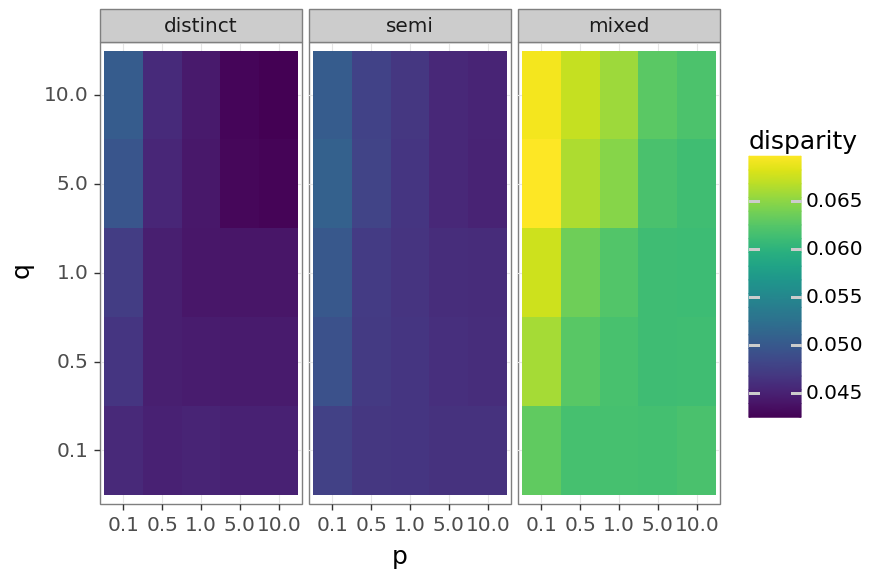

<ggplot: (874613971)>

In [23]:
age_fairness_pq_plot.save(image_dir / "fairness_pq_age_sens.svg", verbose=False, dpi=200)
age_fairness_pq_plot

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

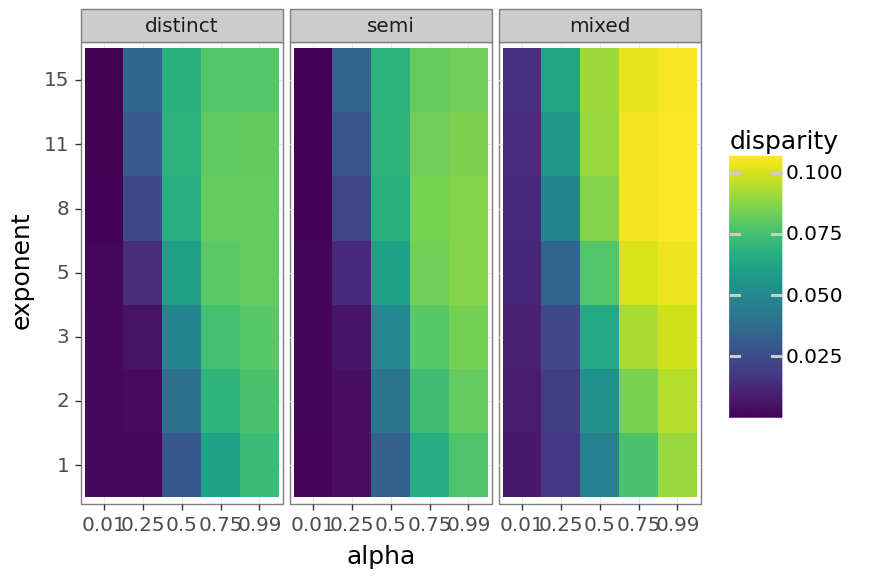

<ggplot: (874613773)>

In [24]:
age_fairness_plot.save(image_dir / "fairness_age_sens.svg", verbose=False, dpi=200)
age_fairness_plot

In [25]:
age_fairness_conf_cw[attr_order].to_latex(table_dir / "fairness_age.tex")
age_fairness_conf_cw

,alpha,exponent,p,q,graph_type,graph_type_no,disparity,sens_attr
216,0.01,1,10.0,10.0,distinct,0,0.001853,age
1423,0.01,15,0.5,5.0,distinct,1,0.002737,age
164,0.01,1,5.0,5.0,distinct,2,0.001832,age
210,0.01,1,10.0,5.0,semi,0,0.003923,age
1156,0.01,11,0.1,5.0,semi,1,0.002587,age
212,0.01,1,10.0,5.0,semi,2,0.000741,age
33,0.01,1,0.1,5.0,mixed,0,0.011086,age
1177,0.01,11,0.5,0.1,mixed,1,0.003226,age
116,0.01,1,1.0,1.0,mixed,2,0.006727,age


In [26]:
# age_fairness_comp.to_latex(table_dir / "fairness_age_comp.tex")
# age_fairness_comp

# Part 2 - Awareness analysis

## baseline: node2vec

In [27]:
image_dir = baseline_dir / "images"
table_dir = baseline_dir / "tables"
image_dir.mkdir(exist_ok=True, parents=True)
table_dir.mkdir(exist_ok=True, parents=True)

In [28]:
region_awareness_plot, region_awareness_conf_baseline = baseline(baseline_df, 'location', 'awareness', np.max, np.max)

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

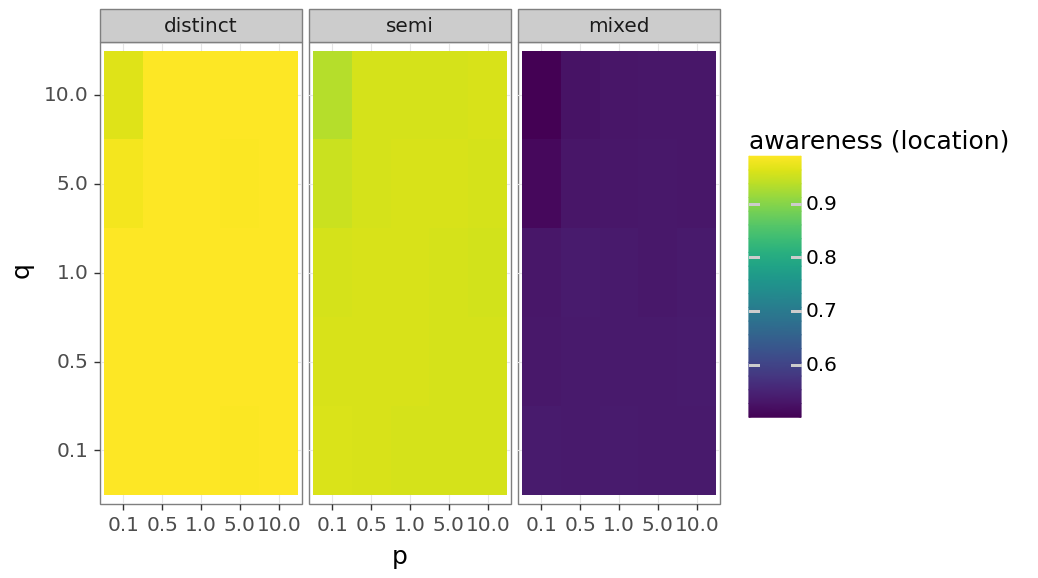

<ggplot: (874470007)>

In [29]:
region_awareness_plot.save(image_dir / "awareness_region.svg", verbose=False, dpi=200)
region_awareness_plot

In [30]:
attr_order = ["graph_type", "graph_type_no", "p", "q", "awareness"]
region_awareness_conf_baseline[attr_order].to_latex(table_dir / "awareness_region.tex")

region_awareness_conf_baseline[attr_order + ["sens_attr"]]

,graph_type,graph_type_no,p,q,awareness,sens_attr
198,distinct,0,10.0,1.0,0.991480,location
10,distinct,1,0.1,0.5,0.967731,location
65,distinct,2,0.5,1.0,0.971332,location
3,semi,0,0.1,0.1,0.934868,location
157,semi,1,5.0,1.0,0.942874,location
86,semi,2,0.5,10.0,0.973795,location
69,mixed,0,0.5,1.0,0.538391,location
7,mixed,1,0.1,0.1,0.597517,location
71,mixed,2,0.5,1.0,0.508102,location


In [31]:
age_awareness_plot, age_awareness_conf_baseline = baseline(baseline_df, 'age', 'awareness', np.max, np.max)

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

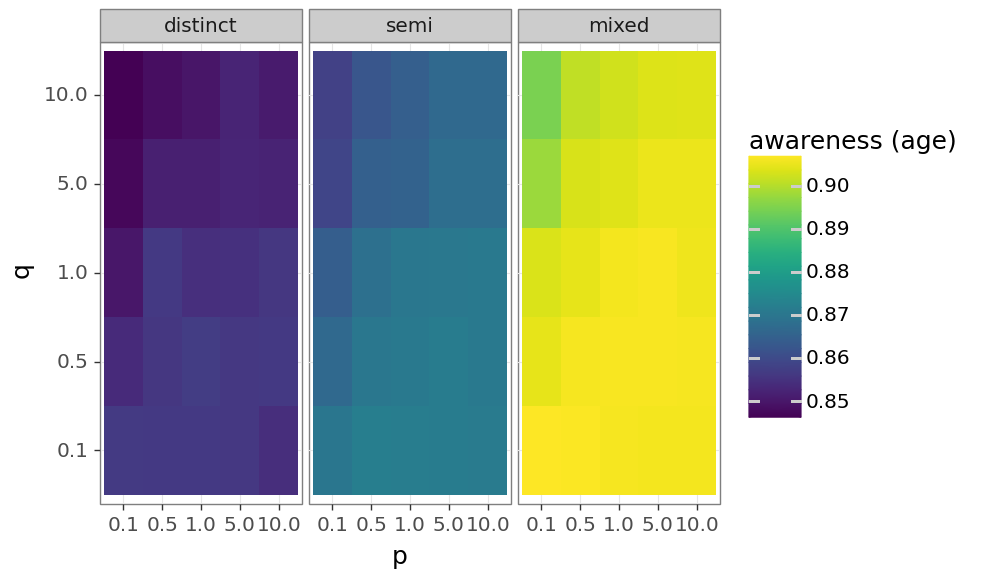

<ggplot: (875029312)>

In [32]:
age_awareness_plot.save(image_dir / "awareness_age.svg", verbose=False, dpi=200)
age_awareness_plot

In [33]:
attr_order = ["graph_type", "graph_type_no", "p", "q", "awareness"]
age_awareness_conf_baseline[attr_order].to_latex(table_dir / "awareness_age.tex")

age_awareness_conf_baseline[attr_order + ["sens_attr"]]

,graph_type,graph_type_no,p,q,awareness,sens_attr
63,distinct,0,0.5,1.0,0.832022,age
190,distinct,1,10.0,0.5,0.883551,age
92,distinct,2,1.0,0.1,0.865210,age
48,semi,0,0.5,0.1,0.874851,age
148,semi,1,5.0,0.5,0.873951,age
158,semi,2,5.0,1.0,0.870322,age
6,mixed,0,0.1,0.1,0.902728,age
151,mixed,1,5.0,0.5,0.903818,age
8,mixed,2,0.1,0.1,0.910757,age


## CrossWalk

In [34]:
image_dir = cw_dir / "images"
table_dir = cw_dir / "tables"
image_dir.mkdir(exist_ok=True, parents=True)
table_dir.mkdir(exist_ok=True, parents=True)

In [35]:
region_awareness_pq_plot, region_awareness_plot, region_awareness_conf_cw = \
    crosswalk(results_df, 'location', 'awareness', np.max, np.max)

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

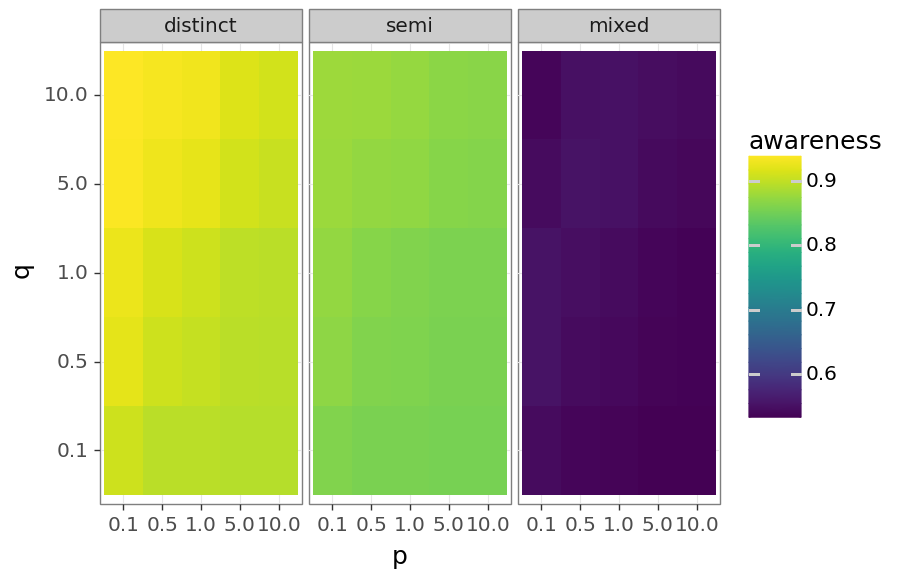

<ggplot: (878509174)>

In [36]:
region_awareness_pq_plot.save(image_dir / "awareness_pq_region.svg", verbose=False, dpi=200)
region_awareness_pq_plot

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

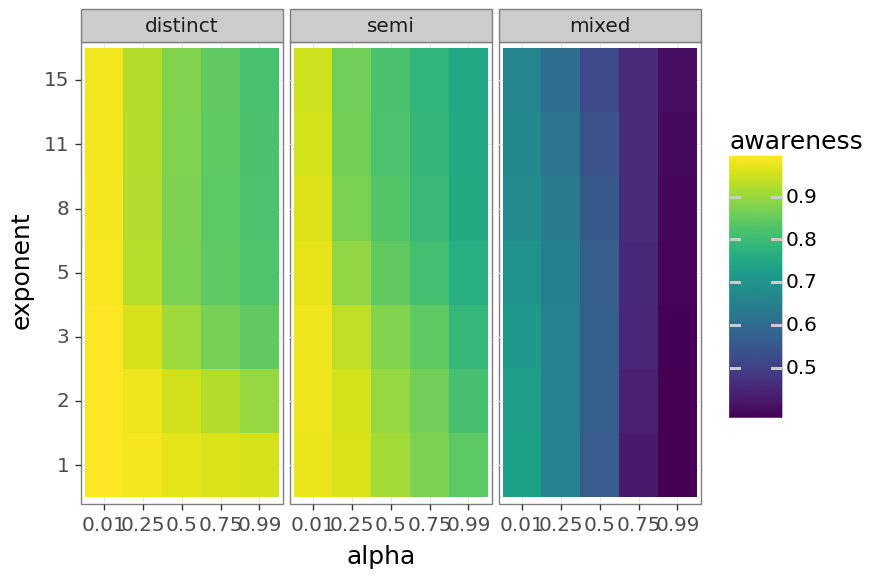

<ggplot: (877961358)>

In [37]:
region_awareness_plot.save(image_dir / "awareness_region_cw.svg", verbose=False, dpi=200)
region_awareness_plot

In [38]:
attr_order = ["graph_type", "graph_type_no", "alpha", "exponent", "p", "q", "awareness"]
region_awareness_conf_cw[attr_order].to_latex(table_dir / "awareness_region.tex")

region_awareness_conf_cw

,alpha,exponent,p,q,graph_type,graph_type_no,awareness,sens_attr
315,0.01,2,1.0,0.1,distinct,0,0.994129,location
244,0.01,2,0.1,1.0,distinct,1,0.975332,location
38,0.01,1,0.1,10.0,distinct,2,0.976028,location
480,0.01,3,0.1,5.0,semi,0,0.965821,location
310,0.01,2,0.5,10.0,semi,1,0.958720,location
230,0.01,2,0.1,0.1,semi,2,0.979277,location
87,0.01,1,0.5,10.0,mixed,0,0.709445,location
169,0.01,1,5.0,5.0,mixed,1,0.806051,location
71,0.01,1,0.5,1.0,mixed,2,0.718620,location


In [39]:
age_awareness_pq_plot, age_awareness_plot, age_awareness_conf_cw = \
    crosswalk(results_df, 'age', 'awareness', np.min, np.max)

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

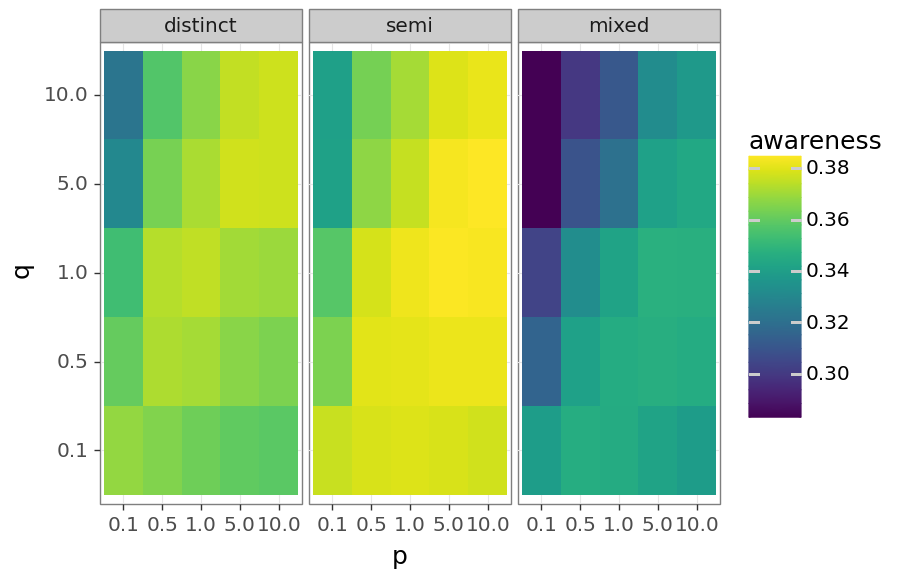

<ggplot: (874509532)>

In [40]:
age_awareness_pq_plot.save(image_dir / "awareness_pq_age.svg", verbose=False, dpi=200)
age_awareness_pq_plot

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

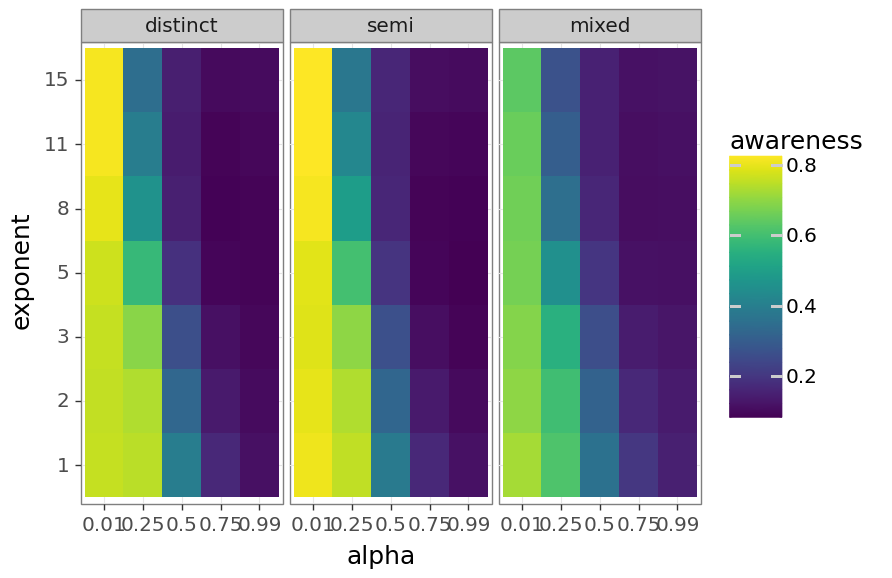

<ggplot: (874509487)>

In [41]:
age_awareness_plot.save(image_dir / "awareness_age_cw.svg", verbose=False, dpi=200)
age_awareness_plot

In [42]:
age_awareness_conf_cw[attr_order].to_latex(table_dir / "awareness_age.tex")
age_awareness_conf_cw

,alpha,exponent,p,q,graph_type,graph_type_no,awareness,sens_attr
216,0.01,1,10.0,10.0,distinct,0,0.810852,age
1369,0.01,15,0.1,1.0,distinct,1,0.809489,age
209,0.01,1,10.0,5.0,distinct,2,0.835277,age
210,0.01,1,10.0,5.0,semi,0,0.779100,age
1156,0.01,11,0.1,5.0,semi,1,0.809860,age
1211,0.01,11,0.5,10.0,semi,2,0.885222,age
33,0.01,1,0.1,5.0,mixed,0,0.691887,age
1177,0.01,11,0.5,0.1,mixed,1,0.812202,age
116,0.01,1,1.0,1.0,mixed,2,0.756048,age


In [43]:
# age_awareness_comp.to_latex(table_dir / "awareness_age_comp.tex")
# age_awareness_comp

## Part 3 - Performance Change

In [44]:
image_dir = cw_dir / "images"
table_dir = cw_dir / "tables"
image_dir.mkdir(exist_ok=True, parents=True)
table_dir.mkdir(exist_ok=True, parents=True)

In [45]:
n2v_merge_attrs = ['graph_type', 'graph_type_no', 'p', 'q']
cw_conf = age_awareness_conf_cw
sens_or_other = 'other'
attr = 'age'
best_confs = cw_conf >> select(*n2v_merge_attrs)
        
base_df = (
    baseline_df >> 
    filter_by(X.attribute == attr, X.metric == 'f1_macro') >> 
    right_join(best_confs, by=n2v_merge_attrs)
)

match sens_or_other:
    case 'sensitive':
        pass
    case 'other':
        attr = 'location' if attr == 'age' else 'age'
    case _:
        raise ArgumentError(sens_or_other)

results = (
    results_df >>
    filter_by(X.sens_attr == attr, X.attribute == sens_or_other, X.metric == 'f1_macro') >>
    right_join(best_confs, by=n2v_merge_attrs)
)

results >> left_join(base_df >> select(X.graph_type, X.graph_type_no, X.value), by=['graph_type', 'graph_type_no'], suffixes=["_cw", "_n2v"])

,alpha,exponent,p,q,sens_attr,attribute,graph_type,graph_type_no,metric,value_cw,value_n2v
0,0.99,15,10.0,10.0,location,other,distinct,0,f1_macro,0.491783,0.662254
1,0.50,2,10.0,10.0,location,other,distinct,0,f1_macro,0.592508,0.662254
2,0.99,1,10.0,10.0,location,other,distinct,0,f1_macro,0.613163,0.662254
3,0.25,5,10.0,10.0,location,other,distinct,0,f1_macro,0.525176,0.662254
4,0.01,11,10.0,10.0,location,other,distinct,0,f1_macro,0.492538,0.662254
...,...,...,...,...,...,...,...,...,...,...,...
310,0.75,1,1.0,1.0,location,other,mixed,2,f1_macro,0.636038,0.653642
311,0.25,3,1.0,1.0,location,other,mixed,2,f1_macro,0.625200,0.653642
312,0.25,2,1.0,1.0,location,other,mixed,2,f1_macro,0.627671,0.653642
313,0.01,2,1.0,1.0,location,other,mixed,2,f1_macro,0.585078,0.653642


In [46]:
pd.merge(results, base_df[['graph_type', 'graph_type_no', 'value']], on=['graph_type', 'graph_type_no'], suffixes=("_cw", "_n2v"), how="left")

,alpha,exponent,p,q,sens_attr,attribute,graph_type,graph_type_no,metric,value_cw,value_n2v
0,0.99,15,10.0,10.0,location,other,distinct,0,f1_macro,0.491783,0.662254
1,0.50,2,10.0,10.0,location,other,distinct,0,f1_macro,0.592508,0.662254
2,0.99,1,10.0,10.0,location,other,distinct,0,f1_macro,0.613163,0.662254
3,0.25,5,10.0,10.0,location,other,distinct,0,f1_macro,0.525176,0.662254
4,0.01,11,10.0,10.0,location,other,distinct,0,f1_macro,0.492538,0.662254
...,...,...,...,...,...,...,...,...,...,...,...
310,0.75,1,1.0,1.0,location,other,mixed,2,f1_macro,0.636038,0.653642
311,0.25,3,1.0,1.0,location,other,mixed,2,f1_macro,0.625200,0.653642
312,0.25,2,1.0,1.0,location,other,mixed,2,f1_macro,0.627671,0.653642
313,0.01,2,1.0,1.0,location,other,mixed,2,f1_macro,0.585078,0.653642


In [47]:
def change(baseline_df, results_df, attr, cw_conf, sens_or_other='sensitive'):
    n2v_merge_attrs = ['graph_type', 'graph_type_no', 'p', 'q']

    best_confs = cw_conf >> select(*n2v_merge_attrs)
            
    baseline_df = (
        baseline_df >> 
        filter_by(X.attribute == attr, X.metric == 'f1_macro') >> 
        right_join(best_confs, by=n2v_merge_attrs)
    )

    # flip attribute to select from crosswalk if other is wanted
    match sens_or_other:
        case 'sensitive':
            pass
        case 'other':
            attr = 'location' if attr == 'age' else 'age'
        case _:
            raise ArgumentError(sens_or_other)
    
    results = (
        results_df >>
        filter_by(X.sens_attr == attr, X.attribute == sens_or_other, X.metric == 'f1_macro') >>
        right_join(best_confs, by=n2v_merge_attrs)
    )
    
    data = (
        results >> 
        left_join(baseline_df >> select(X.graph_type, X.graph_type_no, X.value), 
                  by=['graph_type', 'graph_type_no'], 
                  suffixes=["_cw", "_n2v"]) >>
        select(~X.metric) >> 
        mutate(change = (X.value_cw / X.value_n2v) - 1)
    )
    plot_data = data >> group_by(X.graph_type, X.alpha, X.exponent) >> summarize(val = np.mean(X.change))
    facet_plot = (
        ggplot(plot_data) + 
        geom_tile(aes(x="factor(alpha)", y="factor(exponent)", fill="val")) + 
        facet_wrap('graph_type', ncol=3) +
        labs(x='alpha', y='exponent', fill="relative change")
    )
    
    attr_order = ['graph_type', 'graph_type_no', 'alpha', 'exponent', 'value_cw', 'value_n2v', 'change']
    conf = (
        data >> 
        group_by(X.graph_type, X.graph_type_no) >>
        filter_by(X.change == np.max(X.change)) >>
        select(*attr_order)
    )
    
    conf['control_attr'] = attr

    return facet_plot, conf

In [48]:
age_change_plot, age_change_conf = change(baseline_df, results_df, 'age', region_awareness_conf_cw)

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

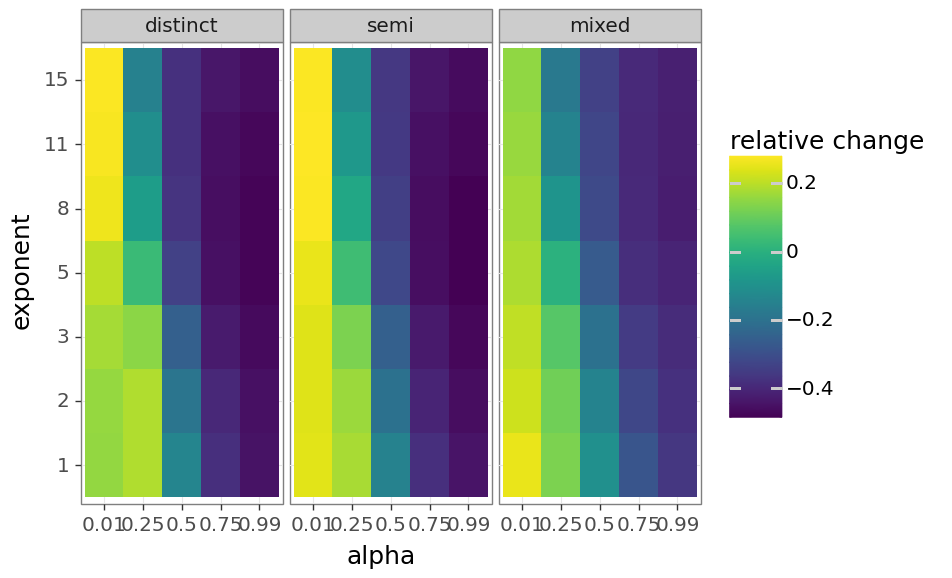

<ggplot: (874258520)>

In [49]:
age_change_plot.save(image_dir / "change_age_sens.svg", verbose=False, dpi=200)
age_change_plot

In [50]:
age_change_conf

,graph_type,graph_type_no,alpha,exponent,value_cw,value_n2v,change,control_attr
25,distinct,0,0.01,15,0.829200,0.666039,0.244971,age
42,distinct,1,0.01,15,0.861894,0.710367,0.213308,age
102,distinct,2,0.01,11,0.864680,0.658924,0.312261,age
119,semi,0,0.01,11,0.824626,0.638362,0.291785,age
150,semi,1,0.01,11,0.851545,0.689845,0.234400,age
204,semi,2,0.01,11,0.901405,0.719508,0.252806,age
238,mixed,0,0.01,1,0.774525,0.619839,0.249559,age
261,mixed,1,0.01,1,0.864627,0.729637,0.185010,age
302,mixed,2,0.01,1,0.832767,0.653974,0.273396,age


In [51]:
attr_order = ['graph_type', 'graph_type_no', 'alpha', 'exponent', 'value_cw', 'value_n2v', 'change']
age_change_conf[attr_order].to_latex(table_dir / "change_age.tex")
age_change_conf

,graph_type,graph_type_no,alpha,exponent,value_cw,value_n2v,change,control_attr
25,distinct,0,0.01,15,0.829200,0.666039,0.244971,age
42,distinct,1,0.01,15,0.861894,0.710367,0.213308,age
102,distinct,2,0.01,11,0.864680,0.658924,0.312261,age
119,semi,0,0.01,11,0.824626,0.638362,0.291785,age
150,semi,1,0.01,11,0.851545,0.689845,0.234400,age
204,semi,2,0.01,11,0.901405,0.719508,0.252806,age
238,mixed,0,0.01,1,0.774525,0.619839,0.249559,age
261,mixed,1,0.01,1,0.864627,0.729637,0.185010,age
302,mixed,2,0.01,1,0.832767,0.653974,0.273396,age


In [52]:
age_change_plot, age_change_conf = change(baseline_df, results_df, 'age', region_awareness_conf_cw, sens_or_other='other')

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

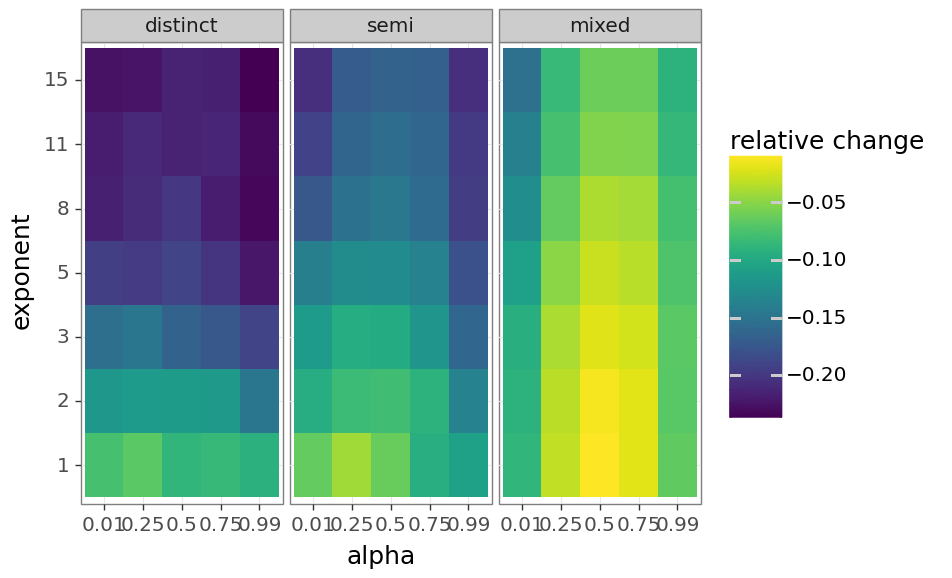

<ggplot: (875010160)>

In [53]:
age_change_plot.save(image_dir / "change_age_other.svg", verbose=False, dpi=200)
age_change_plot

In [54]:
region_change_plot, region_change_conf = change(baseline_df, results_df, 'location', age_awareness_conf_baseline)

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

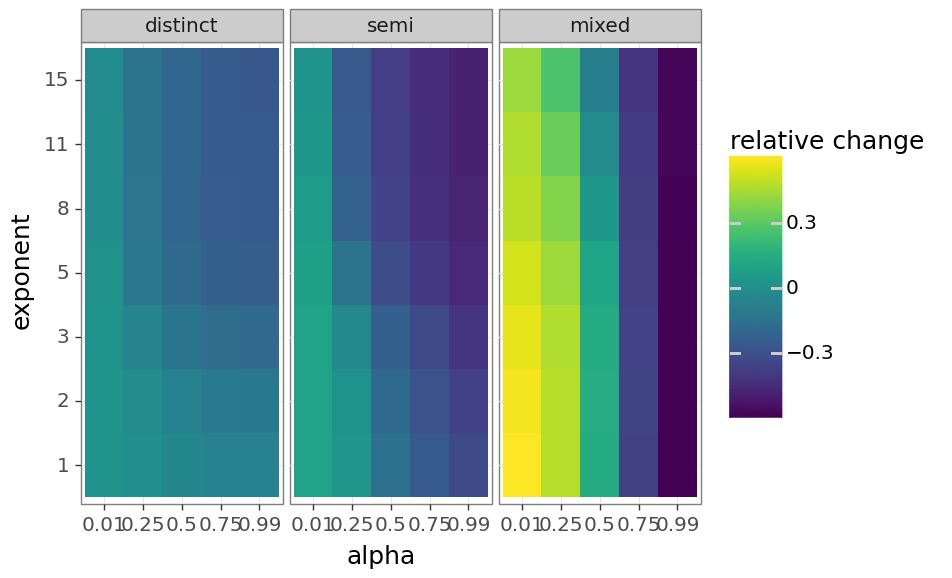

<ggplot: (877967406)>

In [55]:
region_change_plot.save(image_dir / "change_region_sens.svg", verbose=False, dpi=200)
region_change_plot

In [56]:
region_change_conf[attr_order].to_latex(table_dir / "change_region.tex")
region_change_conf

,graph_type,graph_type_no,alpha,exponent,value_cw,value_n2v,change,control_attr
19,distinct,0,0.01,3,0.982838,0.977084,0.005889,location
54,distinct,1,0.01,1,0.889090,0.878603,0.011937,location
91,distinct,2,0.01,2,0.911210,0.874633,0.041821,location
118,semi,0,0.01,1,0.866862,0.775370,0.117999,location
142,semi,1,0.01,2,0.773506,0.712730,0.085272,location
208,semi,2,0.01,3,0.919712,0.841195,0.093340,location
214,mixed,0,0.01,1,0.538542,0.388671,0.385597,location
262,mixed,1,0.01,1,0.645897,0.406025,0.590780,location
284,mixed,2,0.01,1,0.470481,0.267751,0.757158,location


/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

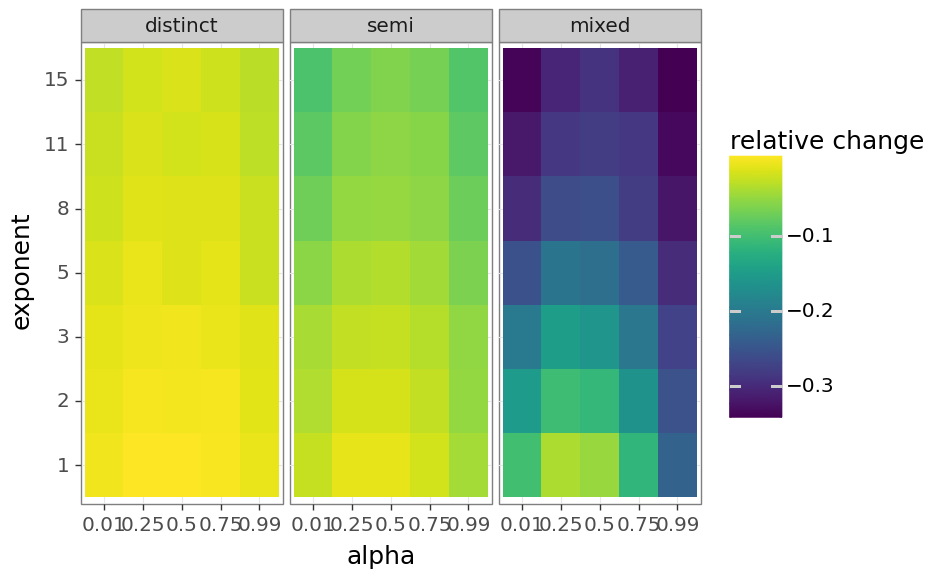

<ggplot: (879339478)>

In [57]:
region_change_plot, region_change_conf = change(baseline_df, results_df, 'location', age_awareness_conf_baseline, sens_or_other='other')
region_change_plot.save(image_dir / "change_region_other.svg", verbose=False, dpi=200)
region_change_plot

In [58]:
baseline_df

,alpha,exponent,p,q,attribute,graph_type,graph_type_no,metric,value
0,NaN,NaN,1.0,0.1,location,distinct,2,f1_macro,0.874633
1,NaN,NaN,1.0,0.1,age,distinct,2,f1_macro,0.691336
2,NaN,NaN,0.1,5.0,location,distinct,2,f1_macro,0.865144
3,NaN,NaN,0.1,5.0,age,distinct,2,f1_macro,0.671033
4,NaN,NaN,10.0,1.0,location,distinct,2,f1_macro,0.873774
...,...,...,...,...,...,...,...,...,...
1245,NaN,NaN,5.0,1.0,age,semi,0,f1_macro_class_2_cond_3,0.842529
1246,NaN,NaN,1.0,10.0,location,semi,0,f1_macro_class_2_cond_3,NaN
1247,NaN,NaN,1.0,10.0,age,semi,0,f1_macro_class_2_cond_3,0.835513
1248,NaN,NaN,0.1,0.1,location,semi,0,f1_macro_class_2_cond_3,NaN


In [59]:
n2v_merge_attrs = ['graph_type', 'graph_type_no', 'p', 'q', 'attribute']
best_n2v = (
    baseline_df >> 
    select(*(n2v_merge_attrs + ['metric', 'value'])) >>
    filter_by(X.metric == 'f1_macro') >> 
    group_by(X.graph_type, X.graph_type_no, X.attribute) >>
    filter_by(X.value == np.max(X.value)) >>
    select(~X.metric)
)
best_n2v['conf'] = 'node2vec'
best_n2v

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,graph_type,graph_type_no,p,q,attribute,value,conf
35,distinct,0,0.5,1.0,age,0.675638,node2vec
8,distinct,0,5.0,0.1,location,0.984648,node2vec
33,distinct,1,5.0,0.5,age,0.719981,node2vec
24,distinct,1,0.1,0.5,location,0.881860,node2vec
49,distinct,2,0.1,0.1,age,0.693674,node2vec
28,distinct,2,1.0,0.5,location,0.881566,node2vec
37,semi,0,0.5,0.1,age,0.674174,node2vec
48,semi,0,0.1,0.1,location,0.779413,node2vec
1,semi,1,1.0,0.1,age,0.711116,node2vec
48,semi,1,0.1,0.1,location,0.713671,node2vec


In [60]:
baseline_df >> filter_by(X.graph_type == 'distinct', X.graph_type_no == "1", X.metric == "f1_macro_cond_3") >> head

,alpha,exponent,p,q,attribute,graph_type,graph_type_no,metric,value
1050,NaN,NaN,1.0,0.1,location,distinct,1,f1_macro_cond_3,NaN
1051,NaN,NaN,1.0,0.1,age,distinct,1,f1_macro_cond_3,0.537447
1052,NaN,NaN,0.1,5.0,location,distinct,1,f1_macro_cond_3,NaN
1053,NaN,NaN,0.1,5.0,age,distinct,1,f1_macro_cond_3,0.526068
1054,NaN,NaN,10.0,1.0,location,distinct,1,f1_macro_cond_3,NaN


In [61]:
results_df >> filter_by(X.graph_type == 'distinct', X.graph_type_no == "1", X.metric == "f1_macro_cond_3") >> head

,alpha,exponent,p,q,sens_attr,attribute,graph_type,graph_type_no,metric,value
25202,0.25,8,5.0,1.0,location,other,distinct,1,f1_macro_cond_3,0.479978
25203,0.25,8,5.0,1.0,location,sensitive,distinct,1,f1_macro_cond_3,NaN
25204,0.99,11,0.1,0.5,location,other,distinct,1,f1_macro_cond_3,0.477598
25205,0.99,11,0.1,0.5,location,sensitive,distinct,1,f1_macro_cond_3,NaN
25206,0.75,15,0.1,0.1,location,other,distinct,1,f1_macro_cond_3,0.463568


In [62]:
@make_symbolic
def ifelse(bools, val_if_true, val_if_false):
    return np.where(bools, val_if_true, val_if_false)

n2v_perf = (
    baseline_df >>
    filter_by(X.metric.str.match("f1_macro_cond_\d+")) >>
    mutate(group=X.metric.str.replace("f1_macro_cond_", "")) >>
    select(~X.metric) >>
    mutate(conf = "node2vec")
)
other_attr_perf = (
    results_df >> 
    filter_by(X.attribute == 'other', X.metric.str.match("f1_macro_cond_\d+")) >>
    mutate(group=X.metric.str.replace("f1_macro_cond_", ""), attribute = ifelse(X.sens_attr == 'location', 'age', 'location')) >>
    select(~X.metric)
)

low_awareness_perf = (
    other_attr_perf >>
    filter_by(X.alpha == 0.99, X.exponent == 15) >>
    mutate(conf = 'low awareness')
)
high_awareness_perf = (
    other_attr_perf >>
    filter_by(X.alpha == 0.01, X.exponent == 1) >>
    mutate(conf = 'high awareness')
)
all_perf = pd.concat([n2v_perf, low_awareness_perf, high_awareness_perf]) >> select(~X.alpha, ~X.exponent, ~X.sens_attr)
all_perf['conf'] = pd.Categorical(all_perf['conf'], categories=['node2vec', 'low awareness', 'high awareness'])
all_perf

,p,q,attribute,graph_type,graph_type_no,value,group,conf
500,1.0,0.1,location,distinct,2,0.875497,0,node2vec
501,1.0,0.1,age,distinct,2,0.730691,0,node2vec
502,0.1,5.0,location,distinct,2,0.865611,0,node2vec
503,0.1,5.0,age,distinct,2,0.708084,0,node2vec
504,10.0,1.0,location,distinct,2,0.872635,0,node2vec
...,...,...,...,...,...,...,...,...
169430,1.0,0.5,location,mixed,1,NaN,7,high awareness
169494,0.5,10.0,location,mixed,1,NaN,7,high awareness
169586,0.1,0.1,location,mixed,1,NaN,7,high awareness
169794,10.0,5.0,location,mixed,1,NaN,7,high awareness


/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


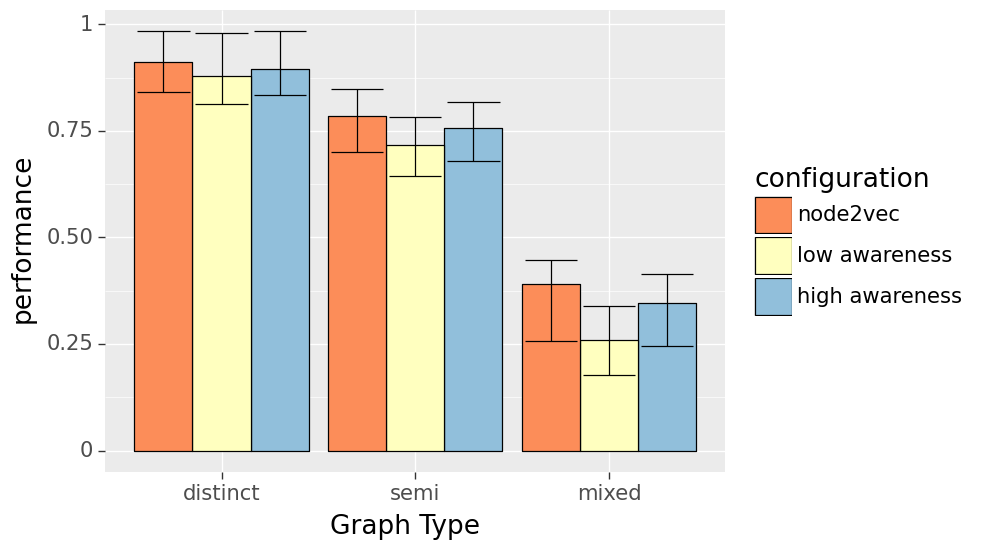

<ggplot: (878388375)>

In [63]:
attr = "location"
plot_data = (
    all_perf >> 
    filter_by(X.attribute == attr) >>
    group_by(X.graph_type, X.graph_type_no, X.conf, X.p, X.q) >>
    summarize(value = np.mean(X.value)) >>
    group_by(X.graph_type, X.conf) >> 
    summarize(mean = X.value.mean(), min=X.value.min(), max=X.value.max())
)

perf_plot = (
    ggplot(plot_data) + 
    geom_bar(aes(x='graph_type', y='mean', fill='conf'), stat='identity', position='dodge', color='black') + 
    geom_errorbar(aes(x='graph_type', ymin='min', ymax='max'), position=position_dodge2(), width=0.9) + 
    labs(x='Graph Type', y='performance', fill='configuration') + 
    scale_fill_brewer(type='diverging', palette='RdYlBu') + 
    theme_grey(base_size=19)
)
perf_plot.save(image_dir / f"performance_{attr}_other.svg", verbose=False, dpi=200, width=8, height=4)
perf_plot

In [64]:
other_attr_perf = (
    results_df >> 
    filter_by(X.attribute == 'other', X.metric == 'f1_macro') >> 
    select(~X.attribute, ~X.metric) >> 
    mutate(attribute = ifelse(X.sens_attr == 'location', 'age', 'location')) >>
    select(~X.sens_attr) >>
    right_join(best_n2v >> select(*n2v_merge_attrs), by=n2v_merge_attrs, suffixes=["_cw", "_n2v"])
)
other_attr_perf

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,alpha,exponent,p,q,graph_type,graph_type_no,value,attribute
0,0.25,15,0.5,1.0,distinct,0,0.492700,age
1,0.01,8,0.5,1.0,distinct,0,0.506124,age
2,0.75,8,0.5,1.0,distinct,0,0.512374,age
3,0.99,2,0.5,1.0,distinct,0,0.570509,age
4,0.50,1,0.5,1.0,distinct,0,0.611382,age
...,...,...,...,...,...,...,...,...
625,0.75,11,0.5,0.5,mixed,2,0.173456,location
626,0.01,15,0.5,0.5,mixed,2,0.162195,location
627,0.25,2,0.5,0.5,mixed,2,0.233793,location
628,0.01,5,0.5,0.5,mixed,2,0.186129,location


In [65]:
high_awareness_conf = (
    other_attr_perf >> 
    filter_by(X.alpha == 0.01, X.exponent == 1)
)
high_awareness_conf['conf'] = 'high awareness'
high_awareness_conf

,alpha,exponent,p,q,graph_type,graph_type_no,value,attribute,conf
14,0.01,1,0.5,1.0,distinct,0,0.629756,age,high awareness
52,0.01,1,5.0,0.1,distinct,0,0.980848,location,high awareness
87,0.01,1,5.0,0.5,distinct,1,0.682892,age,high awareness
109,0.01,1,0.1,0.5,distinct,1,0.858951,location,high awareness
144,0.01,1,0.1,0.1,distinct,2,0.634396,age,high awareness
200,0.01,1,1.0,0.5,distinct,2,0.861467,location,high awareness
223,0.01,1,0.5,0.1,semi,0,0.640516,age,high awareness
275,0.01,1,0.1,0.1,semi,0,0.749076,location,high awareness
305,0.01,1,1.0,0.1,semi,1,0.659967,age,high awareness
345,0.01,1,0.1,0.1,semi,1,0.679565,location,high awareness


In [66]:
low_awareness_conf = (
    other_attr_perf >>
    filter_by(X.alpha == 0.99, X.exponent == 15)
)
low_awareness_conf['conf'] = 'low awareness'
low_awareness_conf

,alpha,exponent,p,q,graph_type,graph_type_no,value,attribute,conf
16,0.99,15,0.5,1.0,distinct,0,0.499455,age,low awareness
44,0.99,15,5.0,0.1,distinct,0,0.979643,location,low awareness
79,0.99,15,5.0,0.5,distinct,1,0.553415,age,low awareness
115,0.99,15,0.1,0.5,distinct,1,0.833551,location,low awareness
152,0.99,15,0.1,0.1,distinct,2,0.517682,age,low awareness
209,0.99,15,1.0,0.5,distinct,2,0.826423,location,low awareness
215,0.99,15,0.5,0.1,semi,0,0.538449,age,low awareness
266,0.99,15,0.1,0.1,semi,0,0.712146,location,low awareness
314,0.99,15,1.0,0.1,semi,1,0.546454,age,low awareness
336,0.99,15,0.1,0.1,semi,1,0.641734,location,low awareness


In [67]:
dfs = []
sel_cols = ['graph_type', 'graph_type_no', 'attribute', 'value', 'conf']
for df in [best_n2v, low_awareness_conf, high_awareness_conf]:
    dfs.append(df >> select(*sel_cols))
all_perf = pd.concat(dfs, ignore_index=True)
all_perf['conf'] = pd.Categorical(all_perf['conf'], categories=['node2vec', 'low awareness', 'high awareness'])
all_perf.head()

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,graph_type,graph_type_no,attribute,value,conf
0,distinct,0,age,0.675638,node2vec
1,distinct,0,location,0.984648,node2vec
2,distinct,1,age,0.719981,node2vec
3,distinct,1,location,0.881860,node2vec
4,distinct,2,age,0.693674,node2vec


/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


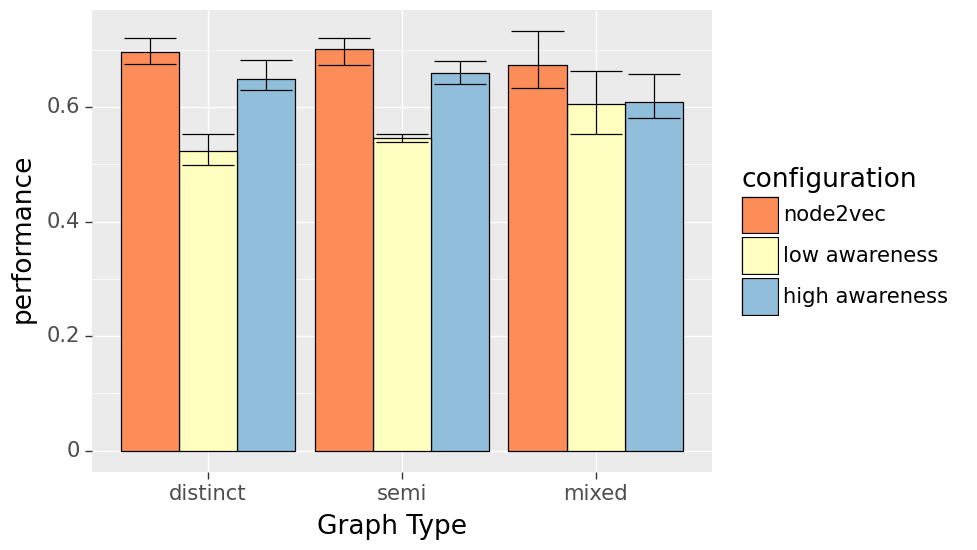

<ggplot: (874270408)>

In [68]:
# performance in control attribute
plot_data = (
    all_perf >>
    filter_by(X.attribute == 'age') >> 
    group_by(X.graph_type, X.graph_type_no, X.conf) >> 
    summarize(value=np.mean(X.value)) >>
    group_by(X.graph_type, X.conf) >> 
    summarize(mean=np.mean(X.value), min=np.min(X.value), max=np.max(X.value))
)
perf_change_plot = (
    ggplot(plot_data) + 
    geom_bar(aes(x='graph_type', y='mean', fill='conf'), stat='identity', position='dodge', color='black') + 
    geom_errorbar(aes(x='graph_type', ymin='min', ymax='max'), position=position_dodge2(), width=0.9) + 
    labs(x='Graph Type', y='performance', fill='configuration') + 
    scale_fill_brewer(type='diverging', palette='RdYlBu') + 
    theme_grey(base_size=19)
)
perf_change_plot.save(image_dir / "performance_other.svg", verbose=False, dpi=200, width=8, height=4)
perf_change_plot

# This is where the plots for the paper are created

In [69]:
sens_attr_perf = (
    results_df >> 
    filter_by(X.attribute == 'sensitive', X.metric.str.match("f1_macro_class_\d+$")) >>
    select(~X.attribute) >> 
    rename(attribute = X.sens_attr)
# >> 
#     select(~X.attribute, ~X.metric) >> 
#     select(~X.sens_attr) >>
#     right_join(best_n2v >> select(*n2v_merge_attrs), by=n2v_merge_attrs, suffixes=["_cw", "_n2v"])
)
sens_attr_perf

,alpha,exponent,p,q,attribute,graph_type,graph_type_no,metric,value
6303,0.75,1,0.1,10.0,age,distinct,0,f1_macro_class_0,0.445582
6307,0.99,5,0.5,0.1,age,distinct,0,f1_macro_class_0,0.273054
6309,0.75,11,1.0,10.0,age,distinct,0,f1_macro_class_0,0.369256
6311,0.25,1,5.0,0.5,age,distinct,0,f1_macro_class_0,0.797867
6315,0.01,8,5.0,5.0,age,distinct,0,f1_macro_class_0,0.817667
...,...,...,...,...,...,...,...,...,...
31475,0.75,5,0.5,0.5,age,mixed,1,f1_macro_class_7,NaN
31479,0.25,3,0.5,1.0,age,mixed,1,f1_macro_class_7,NaN
31485,0.01,5,10.0,1.0,age,mixed,1,f1_macro_class_7,NaN
31497,0.75,5,0.1,5.0,age,mixed,1,f1_macro_class_7,NaN


In [70]:
high_awareness_conf = (
    sens_attr_perf >> 
    filter_by(X.alpha == 0.01, X.exponent == 1) >>
    select(~X.alpha, ~X.exponent)
)
low_awareness_conf = (
    sens_attr_perf >> 
    filter_by(X.alpha == 0.99, X.exponent == 15) >>
    select(~X.alpha, ~X.exponent)
)
high_awareness_conf['conf'] = 'high awareness'
low_awareness_conf['conf'] = 'low awareness'

n2v_merge_attrs = ['graph_type', 'graph_type_no', 'p', 'q', 'attribute']
best_n2v = (
    baseline_df >> 
    select(*(n2v_merge_attrs + ['metric', 'value'])) >>
    filter_by(X.metric.str.match("f1_macro_class_\d+$")) 
)
best_n2v['conf'] = 'node2vec'

dfs = []
sel_cols = ['graph_type', 'graph_type_no', 'p', 'q', 'attribute', 'metric', 'value', 'conf']
for df in [best_n2v, low_awareness_conf, high_awareness_conf]:
    dfs.append(df >> select(*sel_cols))
all_perf = pd.concat(dfs, ignore_index=True)
all_perf['conf'] = pd.Categorical(all_perf['conf'], categories=['node2vec', 'low awareness', 'high awareness'])
all_perf.head()

,graph_type,graph_type_no,p,q,attribute,metric,value,conf
0,distinct,2,1.0,0.1,location,f1_macro_class_0,0.969742,node2vec
1,distinct,2,1.0,0.1,age,f1_macro_class_0,0.654635,node2vec
2,distinct,2,0.1,5.0,location,f1_macro_class_0,0.961917,node2vec
3,distinct,2,0.1,5.0,age,f1_macro_class_0,0.624109,node2vec
4,distinct,2,10.0,1.0,location,f1_macro_class_0,0.969244,node2vec


/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

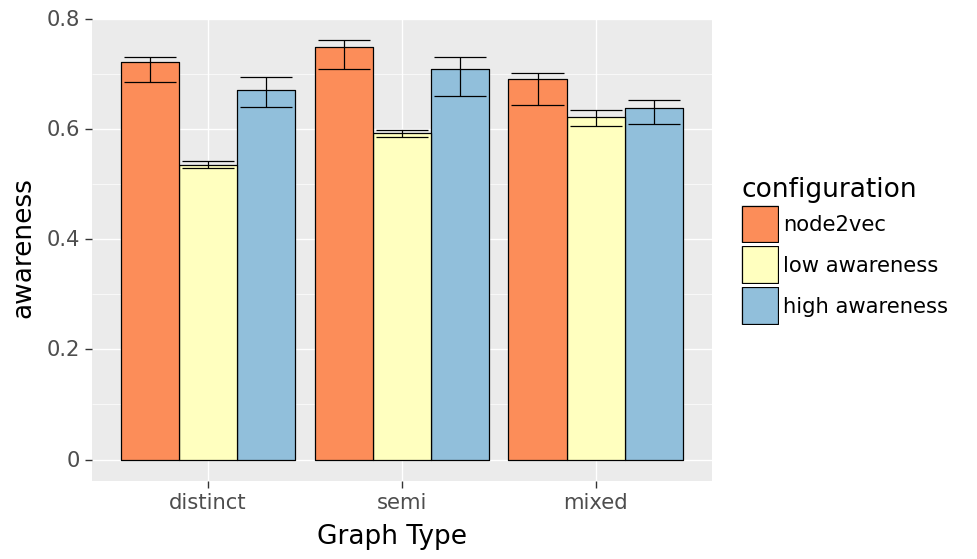

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

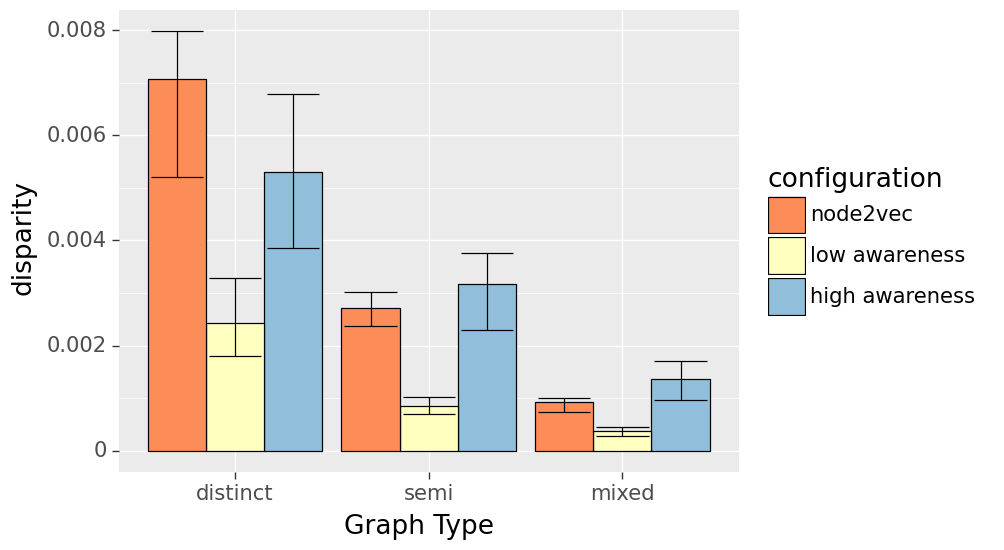

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

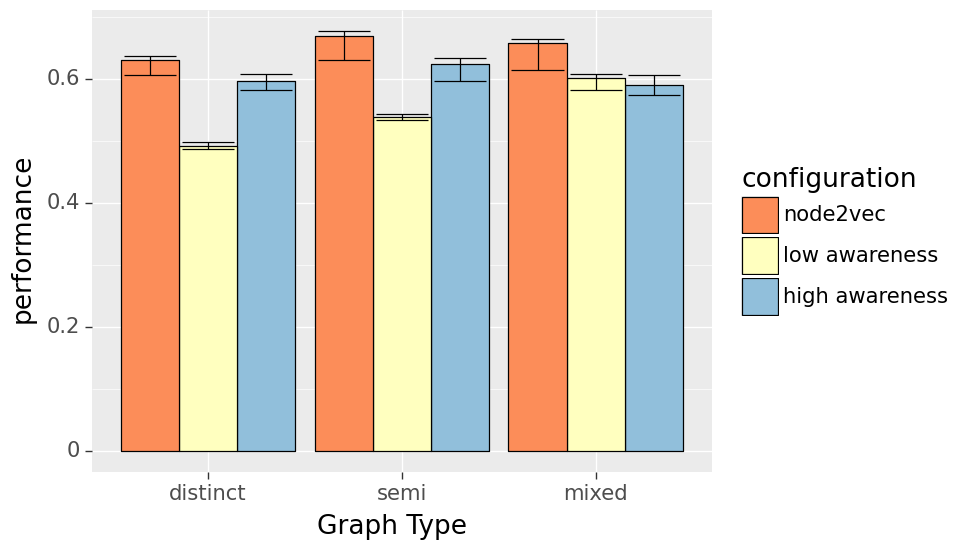

In [114]:
attr = 'age'
# agg_func = np.var
# metric_name = 'disparity'
group_cols = ['graph_type', 'graph_type_no', 'p', 'q', 'attribute', 'conf']
for metric_name, agg_func in [('awareness', np.max), ('disparity', np.var), ('performance', np.mean)]:
    metric_values = (
        all_perf >> 
        filter_by(X.attribute == attr) >> 
        group_by(*group_cols) >>
        summarize(value = agg_func(X.value)) >>
        group_by(X.graph_type, X.p, X.q, X.conf) >>
        summarize(value = np.mean(X.value)) >>
        group_by(X.graph_type, X.conf) >> 
        summarize(mean=np.mean(X.value), min=np.min(X.value), max=np.max(X.value))
    )
    
    metric_plot = (
        ggplot(metric_values) + 
        geom_bar(aes(x='graph_type', y='mean', fill='conf'), stat='identity', position='dodge', color='black') + 
        geom_errorbar(aes(x='graph_type', ymin='min', ymax='max'), position=position_dodge2(), width=0.9) + 
        labs(x='Graph Type', y=metric_name, fill='configuration') + 
        scale_fill_brewer(type='diverging', palette='RdYlBu') + 
        theme_grey(base_size=19)
    )
    metric_plot.save(image_dir / f"{metric_name}_{attr}_sens.svg", verbose=False, dpi=200, width=8, height=4)
    print(metric_plot)

In [72]:
def crosswalk_single(results_df, attr, graph_type, graph_type_no, sens_or_other='sensitive'):
    match sens_or_other:
        case 'sensitive':
            pass
        case 'other':
            attr = 'location' if attr == 'age' else 'age'
        case _:
            raise AttributeError(f"{sens_or_other} - must be 'sensitive' or 'other'")

    data = (
        results_df >> 
        filter_by(X.sens_attr == attr, X.attribute == sens_or_other, X.metric.str.match('f1_macro_class_\d$')) >> 
        filter_by(X.graph_type == graph_type, X.graph_type_no == graph_type_no) >>
        group_by(X.alpha, X.exponent) >>
        summarize(awareness=np.max(X.value), disparity=np.var(X.value))
    )

    def metric_plot(metric):
        return (
            ggplot(data) + 
            geom_tile(aes(x="factor(alpha)", y="factor(exponent)", fill=metric)) + 
            labs(x='alpha', y='exponent', fill=metric) 
        )
    return metric_plot('awareness'), metric_plot('disparity')

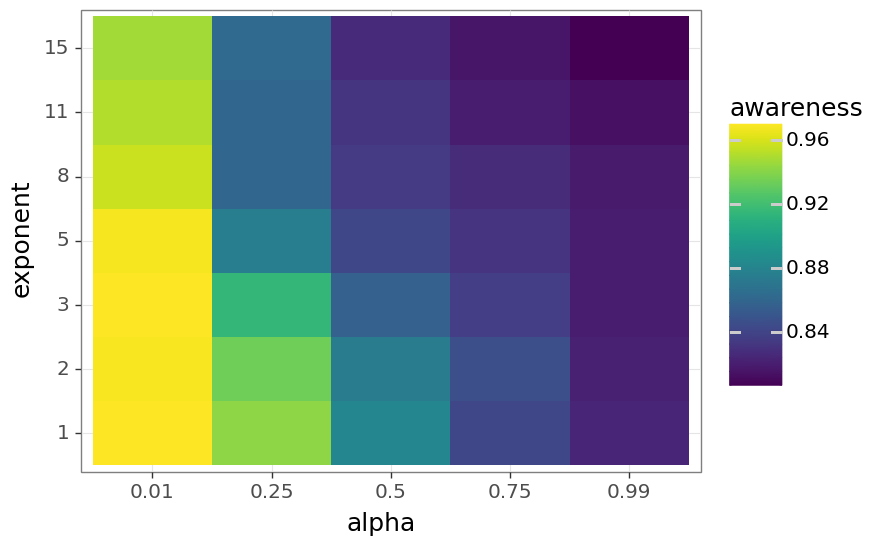

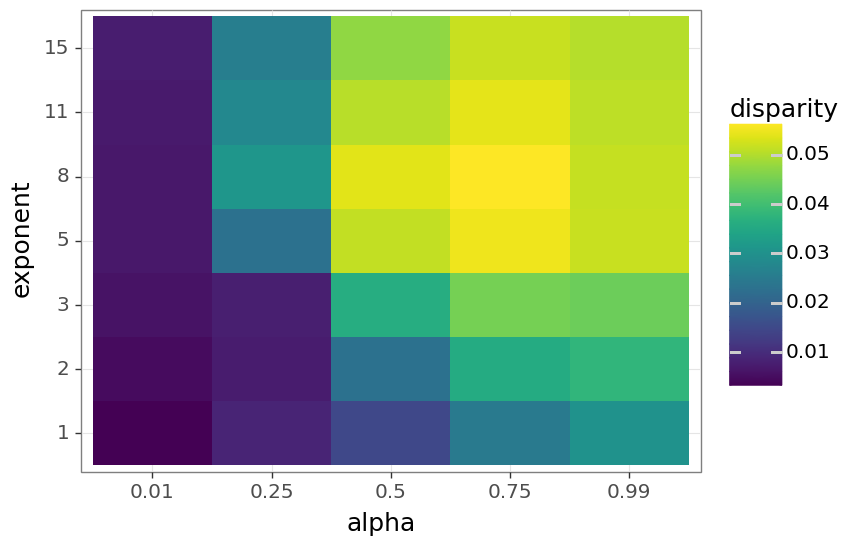

In [73]:
awareness_plot, disparity_plot = crosswalk_single(results_df, 'location', 'semi', '0')
print(awareness_plot)
print(disparity_plot)

# Bonus: unequal impact

In [74]:
cw_dir = results_dir / "cw-f2"
image_dir = cw_dir / "images"
table_dir = cw_dir / "tables"
image_dir.mkdir(exist_ok=True, parents=True)
table_dir.mkdir(exist_ok=True, parents=True)
sort_vals = ['alpha', 'exponent', 'p', 'q', 'graph_type', 'graph_type_no', 'metric']
group_vals = sort_vals[:-1]

In [75]:
r_dfs = []
for file in result_files:
    parts = file.name.split("_")
    graph_type, graph_type_no = parts[1], parts[2]
    df = pd.read_csv(file)
    df['graph_type'] = graph_type
    df['graph_type_no'] = graph_type_no
    df.drop(columns=[col for col in df.columns if col.startswith("f1")], inplace=True)
    df.sens_attr = df.sens_attr.str.lower()
    df.graph_type = pd.Categorical(df.graph_type, categories=["distinct", "semi", "mixed"])
    id_vars = ["alpha", "exponent", "p", "q", "sens_attr", "attribute", "graph_type", "graph_type_no", "support"]
    long_df = pd.melt(df, id_vars = id_vars, var_name='metric', value_name='value')
    r_dfs.append(long_df)
support_df = pd.concat(r_dfs)
support_df.head()

,alpha,exponent,p,q,sens_attr,attribute,graph_type,graph_type_no,support,metric,value
0,0.05,15,0.5,1.0,age,other,distinct,0,1252.0,accuracy,0.982236
1,0.05,15,0.5,1.0,age,sensitive,distinct,0,1252.0,accuracy,0.843067
2,0.75,1,0.1,10.0,age,other,distinct,0,1252.0,accuracy,0.964313
3,0.75,1,0.1,10.0,age,sensitive,distinct,0,1252.0,accuracy,0.604665
4,0.95,3,5.0,10.0,age,other,distinct,0,1252.0,accuracy,0.982780


In [76]:
total_support = support_df >> group_by(X.graph_type, X.graph_type_no) >> summarize(support=X.support.round().astype('int').unique()[0])
total_support

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,graph_type_no,graph_type,support
0,0,distinct,1252
1,1,distinct,10464
2,2,distinct,12114
3,0,semi,4620
4,1,semi,16320
5,2,semi,17543
6,0,mixed,7839
7,1,mixed,16487
8,2,mixed,24611


In [77]:
(
    support_df >>
    filter_by(X.attribute == 'sensitive', X.metric.str.match("support_class_\d$"))
)

,alpha,exponent,p,q,sens_attr,attribute,graph_type,graph_type_no,support,metric,value
3151,0.05,15,0.5,1.0,age,sensitive,distinct,0,1252.0,support_class_0,241.0
3153,0.75,1,0.1,10.0,age,sensitive,distinct,0,1252.0,support_class_0,241.0
3155,0.95,3,5.0,10.0,age,sensitive,distinct,0,1252.0,support_class_0,241.0
3157,0.99,5,0.5,0.1,age,sensitive,distinct,0,1252.0,support_class_0,241.0
3159,0.75,11,1.0,10.0,age,sensitive,distinct,0,1252.0,support_class_0,241.0
...,...,...,...,...,...,...,...,...,...,...,...
28341,0.05,1,0.5,10.0,age,sensitive,mixed,1,16487.0,support_class_7,NaN
28343,0.95,1,0.1,10.0,age,sensitive,mixed,1,16487.0,support_class_7,NaN
28345,0.10,15,5.0,0.1,age,sensitive,mixed,1,16487.0,support_class_7,NaN
28347,0.75,5,0.1,5.0,age,sensitive,mixed,1,16487.0,support_class_7,NaN


In [78]:
# relative group sizes
rel_support = (support_df >>
    filter_by(X.attribute == 'sensitive', X.metric.str.match("support_class_\d$")) >>
    mutate(metric = X.metric.str.replace('support_class_', "")) >>
    rename(n_total=X.support, group=X.metric, n_group=X.value) >>
    mutate(rel_support = X.n_group / X.n_total) >>
    select(~X.alpha, ~X.exponent, ~X.p, ~X.q) >>
    distinct(X.sens_attr, X.graph_type, X.graph_type_no, X.group) 
)
rel_support.loc[rel_support.sens_attr == 'region', 'sens_attr'] = 'location'
rel_support.head()

,sens_attr,attribute,graph_type,graph_type_no,n_total,group,n_group,rel_support
3151,age,sensitive,distinct,0,1252.0,0,241.00,0.192492
6301,age,sensitive,distinct,0,1252.0,1,296.00,0.236422
9451,age,sensitive,distinct,0,1252.0,2,715.00,0.571086
3151,location,sensitive,semi,0,4620.0,0,1570.00,0.339827
6301,location,sensitive,semi,0,4620.0,1,1483.44,0.321091


In [79]:
# performance: p=1, q=1, exponent=1
performance_by_support = (results_df >> 
     filter_by(X.exponent.isin([1,15]), X.attribute == 'sensitive', X.metric.str.match('f1_macro_class_\d$')) >>
     mutate(metric=X.metric.str.replace('f1_macro_class_', "")) >>
     rename(group=X.metric) >>
     left_join(rel_support) 
)
performance_by_support.head()

,alpha,exponent,p,q,sens_attr,attribute,graph_type,graph_type_no,group,value,n_total,n_group,rel_support
0,0.75,1,0.1,10.0,age,sensitive,distinct,0,0,0.445582,1252.0,241.0,0.192492
1,0.25,1,5.0,0.5,age,sensitive,distinct,0,0,0.797867,1252.0,241.0,0.192492
2,0.50,1,0.5,0.1,age,sensitive,distinct,0,0,0.601520,1252.0,241.0,0.192492
3,0.75,15,5.0,10.0,age,sensitive,distinct,0,0,0.338263,1252.0,241.0,0.192492
4,0.01,15,5.0,0.5,age,sensitive,distinct,0,0,0.827305,1252.0,241.0,0.192492


In [80]:
@dfpipe
def process(df, name):
    return (df >>
        select(X.sens_attr, X.graph_type, X.graph_type_no, X.group, X.rel_support, X.value) >>
        rename(**{name: X.value}))
base = performance_by_support >> filter_by(X.alpha == 0.5) >> process('baseline')
lowest = performance_by_support >> filter_by(X.alpha == 0.01, X.exponent==1) >> process('high_awareness')
highest = performance_by_support >> filter_by(X.alpha == 0.99, X.exponent==15) >> process('low_awareness')

comp = base >> left_join(lowest) >> left_join(highest)

def awareness_change_plot(df, sens_attr):
    other = 'location' if sens_attr == 'age' else 'age'
    return (ggplot(df >> filter_by(X.sens_attr == sens_attr)) +
         geom_point(aes(x='rel_support', y='high_awareness - low_awareness'), size=5) + 
         labs(x='relative group size', y='performance change (absolute)') + 
         theme_bw(base_size=19)
    )

region_awareness_change = awareness_change_plot(comp, 'location')
age_awareness_change = awareness_change_plot(comp, 'age')

In [81]:
n2v_perf

,alpha,exponent,p,q,attribute,graph_type,graph_type_no,value,group,conf
500,NaN,NaN,1.0,0.1,location,distinct,2,0.875497,0,node2vec
501,NaN,NaN,1.0,0.1,age,distinct,2,0.730691,0,node2vec
502,NaN,NaN,0.1,5.0,location,distinct,2,0.865611,0,node2vec
503,NaN,NaN,0.1,5.0,age,distinct,2,0.708084,0,node2vec
504,NaN,NaN,10.0,1.0,location,distinct,2,0.872635,0,node2vec
...,...,...,...,...,...,...,...,...,...,...
1095,NaN,NaN,5.0,1.0,age,semi,0,0.668382,3,node2vec
1096,NaN,NaN,1.0,10.0,location,semi,0,NaN,3,node2vec
1097,NaN,NaN,1.0,10.0,age,semi,0,0.649972,3,node2vec
1098,NaN,NaN,0.1,0.1,location,semi,0,NaN,3,node2vec


In [82]:
n2v_perf

,alpha,exponent,p,q,attribute,graph_type,graph_type_no,value,group,conf
500,NaN,NaN,1.0,0.1,location,distinct,2,0.875497,0,node2vec
501,NaN,NaN,1.0,0.1,age,distinct,2,0.730691,0,node2vec
502,NaN,NaN,0.1,5.0,location,distinct,2,0.865611,0,node2vec
503,NaN,NaN,0.1,5.0,age,distinct,2,0.708084,0,node2vec
504,NaN,NaN,10.0,1.0,location,distinct,2,0.872635,0,node2vec
...,...,...,...,...,...,...,...,...,...,...
1095,NaN,NaN,5.0,1.0,age,semi,0,0.668382,3,node2vec
1096,NaN,NaN,1.0,10.0,location,semi,0,NaN,3,node2vec
1097,NaN,NaN,1.0,10.0,age,semi,0,0.649972,3,node2vec
1098,NaN,NaN,0.1,0.1,location,semi,0,NaN,3,node2vec


In [83]:
low = (
    results_df >>
    filter_by(X.exponent == 15, X.alpha == 0.99, X.attribute == 'sensitive', X.metric.str.match('f1_macro_class_\d$')) >>
    mutate(metric=X.metric.str.replace('f1_macro_class_', "")) >>
    rename(group=X.metric) >>
    left_join(rel_support, on=[X.graph_type, X.graph_type_no, X.sens_attr, X.attribute, X.group]) >>
    rename(value_low = X.value) >>
    select(~X.alpha, ~X.exponent)
)
high = (
    results_df >>
    filter_by(X.exponent == 1, X.alpha == 0.01, X.attribute == 'sensitive', X.metric.str.match('f1_macro_class_\d$')) >>
    mutate(metric=X.metric.str.replace('f1_macro_class_', "")) >>
    rename(group=X.metric) >>
    left_join(rel_support, on=[X.graph_type, X.graph_type_no, X.sens_attr, X.attribute, X.group]) >> 
    rename(value_high = X.value) >>
    select(~X.alpha, ~X.exponent)
)

diff = (
    low >> 
    left_join(high) >> 
    group_by(X.graph_type, X.graph_type_no, X.sens_attr, X.attribute, X.group) >>
    summarize(
        diff = np.mean(X.value_high - X.value_low), 
        n_total = first(X.n_total), 
        n_group = first(X.n_group),
        rel_support = first(X.rel_support)
    )
)
diff.head()

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,group,attribute,sens_attr,graph_type_no,graph_type,diff,n_total,n_group,rel_support
0,0,sensitive,age,0,distinct,0.513280,1252.0,241.0,0.192492
1,1,sensitive,age,0,distinct,0.577118,1252.0,296.0,0.236422
2,2,sensitive,age,0,distinct,0.155737,1252.0,715.0,0.571086
3,0,sensitive,location,0,distinct,0.007700,1252.0,186.0,0.148562
4,1,sensitive,location,0,distinct,0.098167,1252.0,633.0,0.505591


In [84]:
rel_support

,sens_attr,attribute,graph_type,graph_type_no,n_total,group,n_group,rel_support
3151,age,sensitive,distinct,0,1252.0,0,241.00,0.192492
6301,age,sensitive,distinct,0,1252.0,1,296.00,0.236422
9451,age,sensitive,distinct,0,1252.0,2,715.00,0.571086
3151,location,sensitive,semi,0,4620.0,0,1570.00,0.339827
6301,location,sensitive,semi,0,4620.0,1,1483.44,0.321091
...,...,...,...,...,...,...,...,...
12601,age,sensitive,mixed,1,16487.0,3,NaN,NaN
15751,age,sensitive,mixed,1,16487.0,4,NaN,NaN
18901,age,sensitive,mixed,1,16487.0,5,NaN,NaN
22051,age,sensitive,mixed,1,16487.0,6,NaN,NaN


In [105]:
n2v_perf = (
    baseline_df >>
    filter_by(X.metric.str.match("f1_macro_class_\d+$")) >>
    mutate(group=X.metric.str.replace("f1_macro_class_", "")) >>
    select(~X.metric) >>
    mutate(conf = "node2vec")
)
other_attr_perf = (
    results_df >> 
    filter_by(X.attribute == 'sensitive', X.metric.str.match("f1_macro_class_\d+$")) >>
    mutate(group=X.metric.str.replace("f1_macro_class_", ""), attribute = X.sens_attr) >>
    select(~X.metric)
)

low_awareness_perf = (
    other_attr_perf >>
    filter_by(X.alpha == 0.99, X.exponent == 15) >>
    mutate(conf = 'low awareness')
)
high_awareness_perf = (
    other_attr_perf >>
    filter_by(X.alpha == 0.01, X.exponent == 1) >>
    mutate(conf = 'high awareness')
)
all_perf = pd.concat([n2v_perf, low_awareness_perf, high_awareness_perf]) >> select(~X.alpha, ~X.exponent, ~X.sens_attr)
all_perf['conf'] = pd.Categorical(all_perf['conf'], categories=['node2vec', 'low awareness', 'high awareness'])
all_perf = (
    all_perf >> 
    left_join(rel_support >> mutate(attribute=X.sens_attr) >> select(~X.sens_attr)) >> 
    filter_by(X.value.notna())
)
all_perf

,p,q,attribute,graph_type,graph_type_no,value,group,conf,n_total,n_group,rel_support
0,1.0,0.1,location,distinct,2,0.969742,0,node2vec,12114.0,4350.0,0.359089
1,1.0,0.1,age,distinct,2,0.654635,0,node2vec,12114.0,1941.0,0.160228
2,0.1,5.0,location,distinct,2,0.961917,0,node2vec,12114.0,4350.0,0.359089
3,0.1,5.0,age,distinct,2,0.624109,0,node2vec,12114.0,1941.0,0.160228
4,10.0,1.0,location,distinct,2,0.969244,0,node2vec,12114.0,4350.0,0.359089
...,...,...,...,...,...,...,...,...,...,...,...
10370,1.0,0.5,age,mixed,1,0.940954,2,high awareness,16487.0,11243.0,0.681931
10371,0.5,10.0,age,mixed,1,0.919938,2,high awareness,16487.0,11243.0,0.681931
10372,0.1,0.1,age,mixed,1,0.940101,2,high awareness,16487.0,11243.0,0.681931
10373,10.0,5.0,age,mixed,1,0.943417,2,high awareness,16487.0,11243.0,0.681931


/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 24 rows containing missing values.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 24 rows c

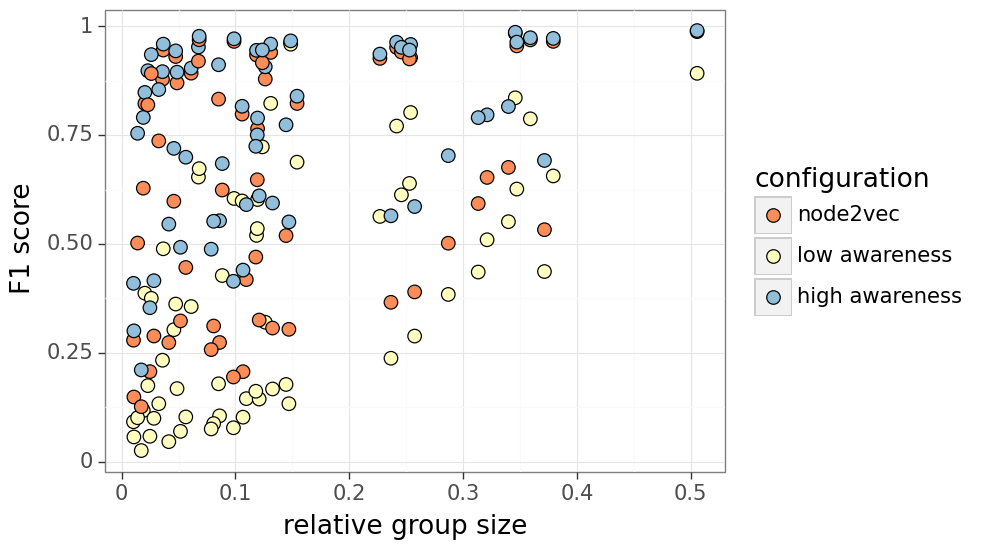

<ggplot: (878218892)>

In [106]:
plot_data_sens = (
    all_perf >> 
    group_by(X.graph_type, X.graph_type_no, X.group, X.conf, X.attribute) >>
    summarize(value = np.mean(X.value), rel_support=first(X.rel_support)) >> 
    filter_by(X.attribute == 'location')
)
performance_by_groupsize_sens = (
    ggplot(plot_data_sens) + 
    geom_point(aes(x='rel_support', y='value', fill='conf'), size=5) + 
    labs(x='relative group size', y='F1 score', fill='configuration') + 
    theme_bw(base_size=19) + 
    scale_fill_brewer(type='diverging', palette='RdYlBu')
)
performance_by_groupsize_sens.save(image_dir / "acc_by_group_location_sens.svg", verbose=False, dpi=200, width=8, height=4)
performance_by_groupsize_sens

In [110]:
# plot_data_sens = (
#     all_perf >> 
#     group_by(X.graph_type, X.graph_type_no, X.group, X.conf, X.attribute) >>
#     summarize(value = np.mean(X.value), rel_support=first(X.rel_support)) >> 
#     filter_by(X.attribute == 'age')
# )
# performance_by_groupsize_sens = (
#     ggplot(plot_data_sens) + 
#     geom_point(aes(x='rel_support', y='value', fill='conf'), size=5) + 
#     labs(x='relative group size', y='F1 score', fill='configuration') + 
#     theme_bw(base_size=19) + 
#     scale_fill_brewer(type='diverging', palette='RdYlBu')
# )
# performance_by_groupsize_sens.save(image_dir / "acc_by_group_age_sens.svg", verbose=False, dpi=200, width=8, height=4)
# performance_by_groupsize_sens

In [107]:
n2v_perf = (
    baseline_df >>
    filter_by(X.metric.str.match("f1_macro_cond_\d+")) >>
    mutate(group=X.metric.str.replace("f1_macro_cond_", "")) >>
    select(~X.metric) >>
    mutate(conf = "node2vec")
)
other_attr_perf = (
    results_df >> 
    filter_by(X.attribute == 'other', X.metric.str.match("f1_macro_cond_\d+")) >>
    mutate(group=X.metric.str.replace("f1_macro_cond_", ""), attribute = ifelse(X.sens_attr == 'location', 'age', 'location')) >>
    select(~X.metric)
)

low_awareness_perf = (
    other_attr_perf >>
    filter_by(X.alpha == 0.99, X.exponent == 15) >>
    mutate(conf = 'low awareness')
)
high_awareness_perf = (
    other_attr_perf >>
    filter_by(X.alpha == 0.01, X.exponent == 1) >>
    mutate(conf = 'high awareness')
)
all_perf = pd.concat([n2v_perf, low_awareness_perf, high_awareness_perf]) >> select(~X.alpha, ~X.exponent, ~X.sens_attr)
all_perf['conf'] = pd.Categorical(all_perf['conf'], categories=['node2vec', 'low awareness', 'high awareness'])
all_perf

,p,q,attribute,graph_type,graph_type_no,value,group,conf
500,1.0,0.1,location,distinct,2,0.875497,0,node2vec
501,1.0,0.1,age,distinct,2,0.730691,0,node2vec
502,0.1,5.0,location,distinct,2,0.865611,0,node2vec
503,0.1,5.0,age,distinct,2,0.708084,0,node2vec
504,10.0,1.0,location,distinct,2,0.872635,0,node2vec
...,...,...,...,...,...,...,...,...
169430,1.0,0.5,location,mixed,1,NaN,7,high awareness
169494,0.5,10.0,location,mixed,1,NaN,7,high awareness
169586,0.1,0.1,location,mixed,1,NaN,7,high awareness
169794,10.0,5.0,location,mixed,1,NaN,7,high awareness


/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 24 rows containing missing values.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 24 rows c

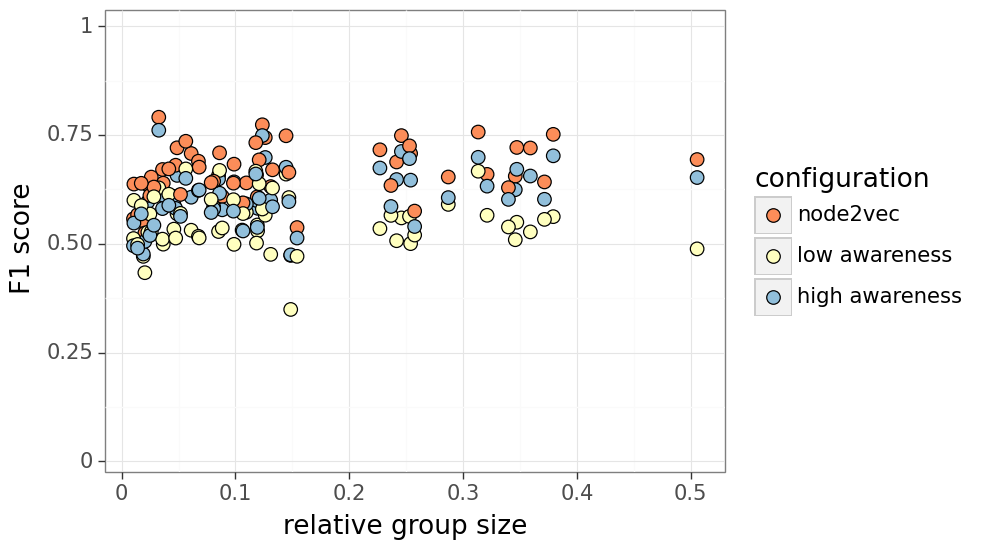

<ggplot: (877773251)>

In [108]:
plot_data_other = (
    all_perf >> 
    left_join(rel_support >> mutate(attribute=ifelse(X.sens_attr == 'location', 'age', 'location')) >> select(~X.sens_attr)) >> 
    filter_by(X.value.notna()) >>
    group_by(X.graph_type, X.graph_type_no, X.group, X.conf, X.attribute) >>
    summarize(value = np.mean(X.value), rel_support=first(X.rel_support)) >> 
    filter_by(X.attribute == 'age')
)
performance_by_groupsize_other = (
    ggplot(plot_data_other) + 
    geom_point(aes(x='rel_support', y='value', fill='conf'), size=5) + 
    labs(x='relative group size', y='F1 score', fill='configuration') + 
    theme_bw(base_size=19) + 
    lims(y=(0.025,0.99)) + 
    scale_fill_brewer(type='diverging', palette='RdYlBu')
)
performance_by_groupsize_other.save(image_dir / "acc_by_group_age_other.svg", verbose=False, dpi=200, width=8, height=4)
performance_by_groupsize_other

In [109]:
# plot_data_other = (
#     all_perf >> 
#     left_join(rel_support >> mutate(attribute=ifelse(X.sens_attr == 'age', 'location', 'age')) >> select(~X.sens_attr)) >> 
#     filter_by(X.value.notna()) >>
#     group_by(X.graph_type, X.graph_type_no, X.group, X.conf, X.attribute) >>
#     summarize(value = np.mean(X.value), rel_support=first(X.rel_support)) >> 
#     filter_by(X.attribute == 'location')
# )
# performance_by_groupsize_other = (
#     ggplot(plot_data_other) + 
#     geom_point(aes(x='rel_support', y='value', fill='conf'), size=5) + 
#     labs(x='relative group size', y='F1 score', fill='configuration') + 
#     theme_bw(base_size=19) + 
#     lims(y=(0.025,0.99)) + 
#     scale_fill_brewer(type='diverging', palette='RdYlBu')
# )
# performance_by_groupsize_other.save(image_dir / "acc_by_group_location_other.svg", verbose=False, dpi=200, width=8, height=4)
# performance_by_groupsize_other

In [111]:
plot_data_sens['sens_attr'] = 'sensitive'
plot_data_other['sens_attr'] = 'control'

plot_data = pd.concat([plot_data_sens, plot_data_other])
plot_data['sens_attr'] = pd.Categorical(plot_data['sens_attr'], categories=['sensitive', 'control'])
plot_data

,attribute,conf,group,graph_type_no,graph_type,value,rel_support,sens_attr
1,location,node2vec,0,0,distinct,0.962590,0.148562,sensitive
3,location,low awareness,0,0,distinct,0.958579,0.148562,sensitive
5,location,high awareness,0,0,distinct,0.966280,0.148562,sensitive
7,location,node2vec,1,0,distinct,0.987511,0.505591,sensitive
9,location,low awareness,1,0,distinct,0.891787,0.505591,sensitive
...,...,...,...,...,...,...,...,...
286,age,low awareness,8,2,mixed,0.602011,0.078719,control
287,age,high awareness,8,2,mixed,0.571971,0.078719,control
288,age,node2vec,9,2,mixed,0.613472,0.051738,control
289,age,low awareness,9,2,mixed,0.570002,0.051738,control


/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 48 rows containing missing values.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of obse

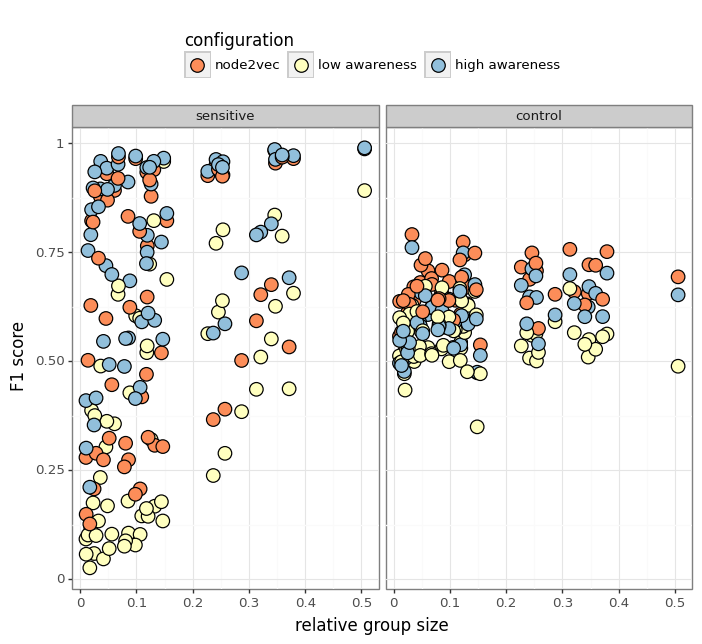

<ggplot: (877712261)>

In [112]:
performance_by_groupsize = (
    ggplot(plot_data) + 
    geom_point(aes(x='rel_support', y='value', fill='conf'), size=5) + 
    facet_wrap("~sens_attr", nrow=1) + 
    labs(x='relative group size', y='F1 score', fill='configuration') + 
    theme_bw(base_size=12) + 
    theme(legend_position="top") + 
    scale_fill_brewer(type='diverging', palette='RdYlBu') 
    # theme(legend_position=(.8,.3), legend_direction="vertical")
)
performance_by_groupsize.save(image_dir / "acc_by_group_location.svg", verbose=False, dpi=200, width=12, height=6)
performance_by_groupsize

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


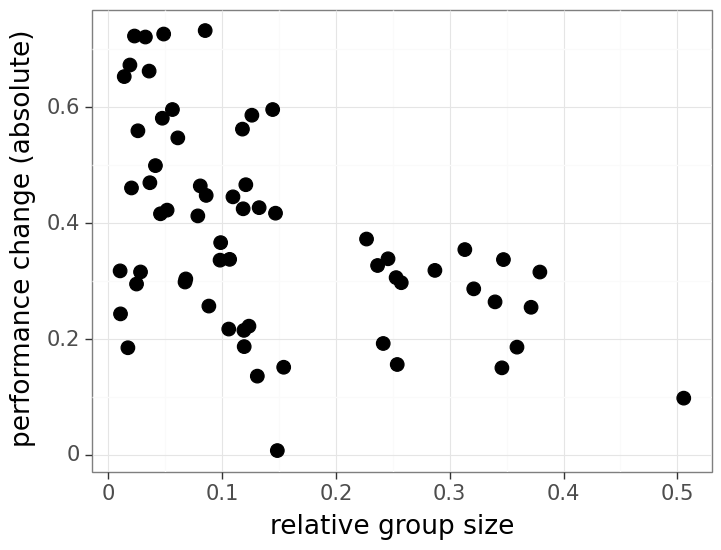

<ggplot: (877985582)>

In [113]:
plot_data = diff >> filter_by(X.sens_attr == 'location')
performance_change_plot = (
    ggplot(plot_data) +
    geom_point(aes(x='rel_support', y='diff'), size=5) + 
    labs(x='relative group size', y='performance change (absolute)') + 
    theme_bw(base_size=19)
)
performance_change_plot.save(image_dir / "performance_change_by_group_region.svg", verbose=False, dpi=200, width=8, height=6)
performance_change_plot

In [115]:
best_and_worst = (all_results_df >>
     filter_by(X.attribute == 'sensitive', X.metric == 'f1_macro') >>
     group_by(X.sens_attr, X.graph_type, X.graph_type_no, X.alpha) >>
     summarize(
         highest=np.max(X.value), 
         lowest=np.min(X.value)
     )
)
best_and_worst.head()

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,alpha,graph_type_no,graph_type,sens_attr,highest,lowest
0,0.01,0,distinct,age,0.859337,0.723071
1,0.05,0,distinct,age,0.859581,0.747479
2,0.10,0,distinct,age,0.858693,0.677306
3,0.25,0,distinct,age,0.824864,0.524827
4,0.50,0,distinct,age,0.608344,0.417518


In [116]:
# hline_df = n2v_conf.groupby(by="graph_type").agg(baseline=(metric_name, 'mean')).reset_index()

In [117]:
sort_vals = ['p', 'q', 'graph_type', 'graph_type_no', 'metric']
group_vals = sort_vals[:-1]
_, region_performance_baseline = baseline(baseline_df, 'location', 'f1-score', np.mean, np.max)
_, age_performance_baseline = baseline(baseline_df, 'age', 'f1-score', np.mean, np.max)

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this w

In [118]:
defaults = all_results_df >> filter_by(X.attribute == 'sensitive', X.metric == 'f1_macro', X.exponent.isin([1,15]), X.p == 1, X.q == 1)
defaults_1 = defaults >> filter_by(X.exponent==1) >> rename(**{"exponent=1": X.value}) >> select(~X.exponent)
defaults_15 = defaults >> filter_by(X.exponent==15) >> rename(**{"exponent=15": X.value}) >> select(~X.exponent)
configurations = (defaults_1 >> 
     right_join(defaults_15) >>
     right_join(best_and_worst) >>
     select(X.alpha, X.sens_attr, X.graph_type, X.graph_type_no, X['exponent=1'], X['exponent=15'], X.highest, X.lowest) >>
     gather('configuration', 'value', [X['exponent=1'], X['exponent=15'], X.highest, X.lowest]) 
)
configurations['configuration'] = pd.Categorical(configurations['configuration'], categories=['highest', 'exponent=1', 'exponent=15', 'lowest'])

def config_plot_sens(sens, n2v_conf):
    return (ggplot(configurations >> filter_by(X.sens_attr == sens)) +
         geom_line(aes(x='alpha', y='value', color='configuration'), size=1.5) + 
         geom_hline(aes(yintercept='f1-score'), data=n2v_conf, linetype='dotted') +\
         facet_grid("graph_type ~ graph_type_no") + 
         labs(y=f'performance ({sens}) [sensitive]') +
         theme(axis_text_x = element_text(angle=45))
    )
region_config_plot_sens = config_plot_sens('location', region_performance_baseline)
age_config_plot_sens = config_plot_sens('age', age_performance_baseline)

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/facets/strips.py:216: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positi

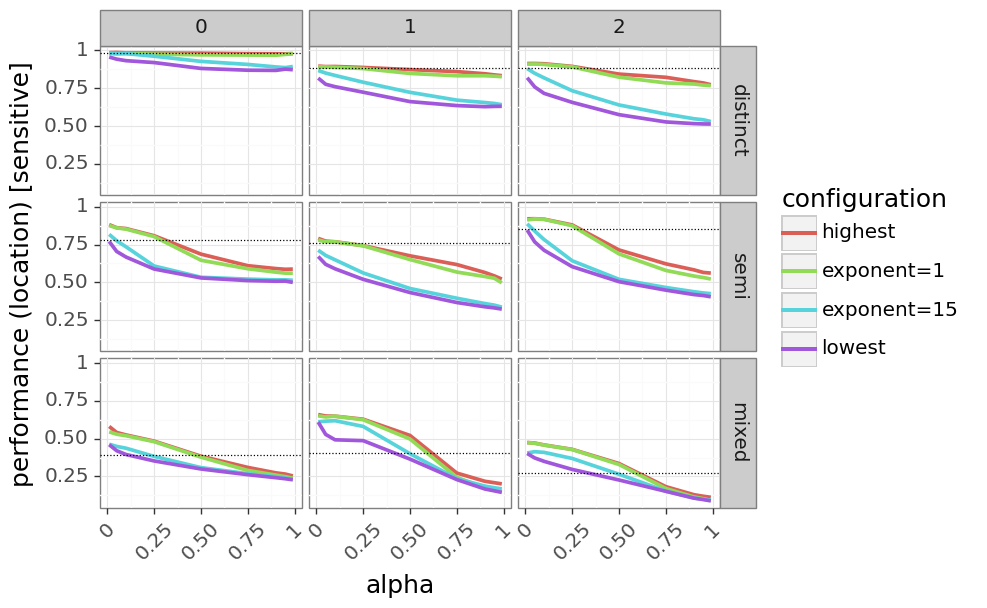

<ggplot: (877699169)>

In [119]:
region_config_plot_sens.save(image_dir / "awareness_config_sens_region.svg", verbose=False, dpi=200)
region_config_plot_sens

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/facets/strips.py:216: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positi

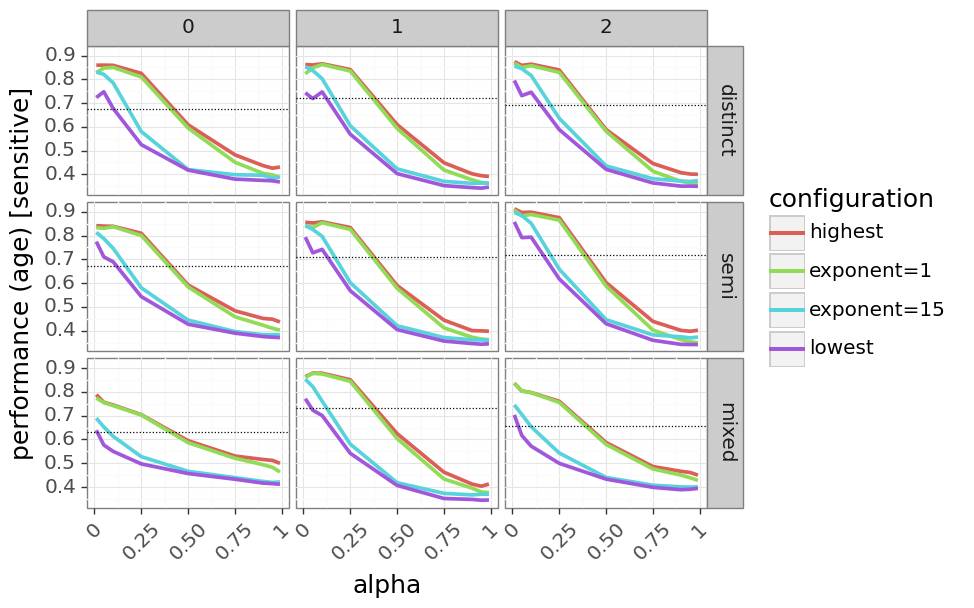

<ggplot: (878952572)>

In [120]:
age_config_plot_sens.save(image_dir / "awareness_config_sens_age.svg", verbose=False, dpi=200)
age_config_plot_sens

In [121]:
o_best_and_worst = (all_results_df >>
     filter_by(X.attribute == 'other', X.metric == 'f1_macro') >>
     group_by(X.sens_attr, X.graph_type, X.graph_type_no, X.alpha) >>
     summarize(
         highest=np.max(X.value), 
         lowest=np.min(X.value)
     )
)

o_defaults = all_results_df >> filter_by(X.attribute == 'other', X.metric == 'f1_macro', X.exponent.isin([1,15]), X.p == 1, X.q == 1)
o_defaults_1 = o_defaults >> filter_by(X.exponent==1) >> rename(**{"exponent=1": X.value}) >> select(~X.exponent)
o_defaults_15 = o_defaults >> filter_by(X.exponent==15) >> rename(**{"exponent=15": X.value}) >> select(~X.exponent)
o_configurations = (o_defaults_1 >> 
     right_join(o_defaults_15) >>
     right_join(o_best_and_worst) >>
     select(X.alpha, X.sens_attr, X.graph_type, X.graph_type_no, X['exponent=1'], X['exponent=15'], X.highest, X.lowest) >>
     gather('configuration', 'value', [X['exponent=1'], X['exponent=15'], X.highest, X.lowest]) 
)
o_configurations['configuration'] = pd.Categorical(o_configurations['configuration'], categories=['highest', 'exponent=1', 'exponent=15', 'lowest'])
def config_plot_other(sens, n2v_conf):
    other = 'location' if sens == 'age' else 'age'
    return (ggplot(o_configurations >> filter_by(X.sens_attr == sens)) +
         geom_line(aes(x='alpha', y='value', color='configuration'), size=1.5) + 
         geom_hline(aes(yintercept='f1-score'), data=n2v_conf, linetype='dotted') +
         facet_grid("graph_type ~ graph_type_no") + 
         labs(y=f'performance ({other}) [control]') +
         theme(axis_text_x = element_text(angle=45))
    )
region_config_plot_other = config_plot_other('age', region_performance_baseline)
age_config_plot_other = config_plot_other('location', age_performance_baseline)

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/dfply/base.py:307: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/facets/strips.py:216: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positi

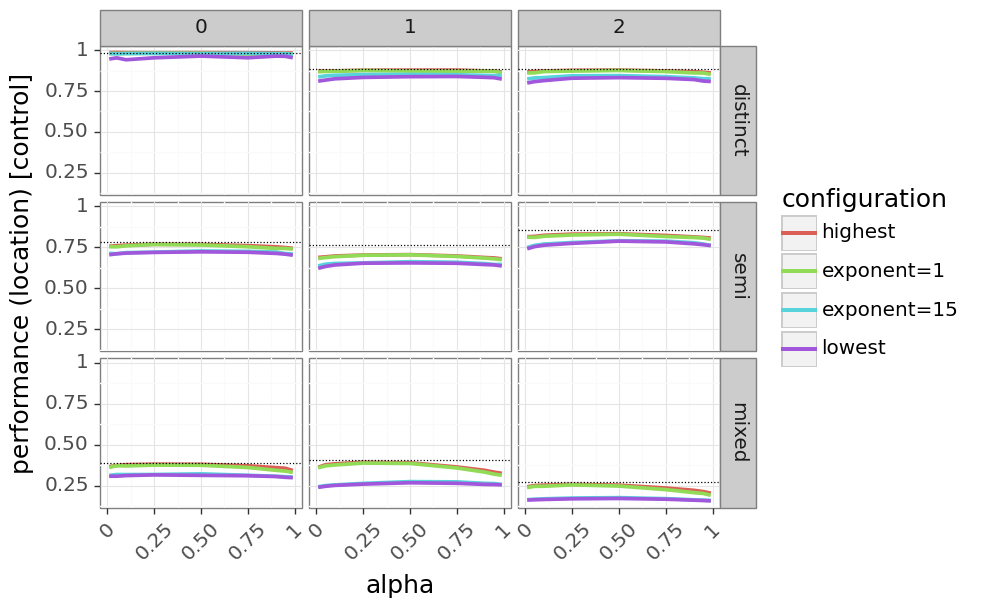

<ggplot: (875148126)>

In [122]:
region_config_plot_other.save(image_dir / "awareness_config_other_region.svg", verbose=False, dpi=200)
region_config_plot_other

/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/jf/.pyenv/versions/3.10.0/envs/arm_310thesis/lib/python3.10/site-packages/plotnine/facets/strips.py:216: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positi

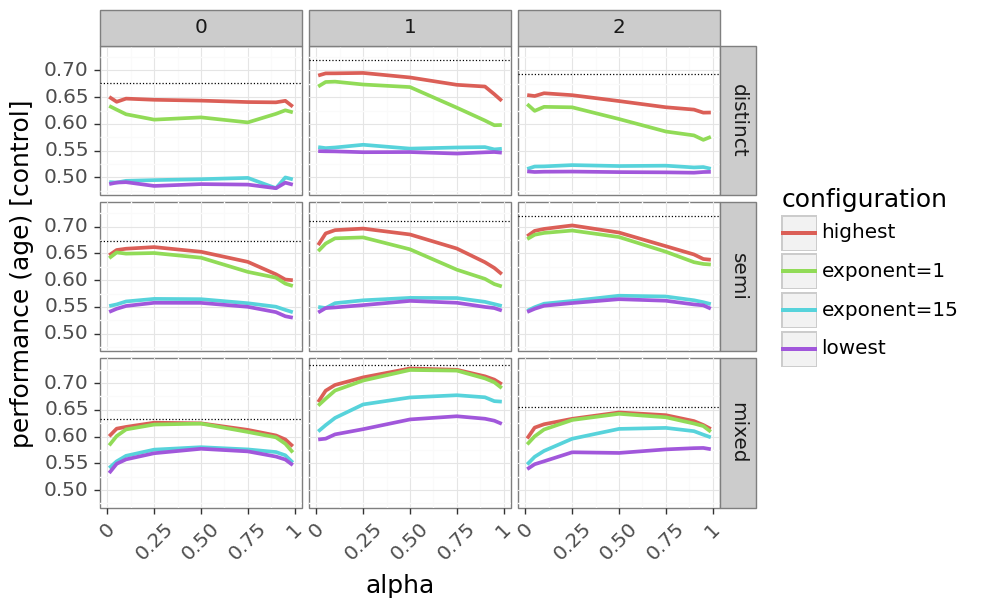

<ggplot: (879262714)>

In [123]:
age_config_plot_other.save(image_dir / "awareness_config_other_age.svg", verbose=False, dpi=200)
age_config_plot_other